# Setup & I/O

### Import packages

In [1]:
%matplotlib inline

from __future__ import print_function
import os, sys
from collections import Counter, defaultdict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import math

In [2]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (12,8)

### Import training dataset

In [3]:
%%time
DATA_DIR = '~/Downloads/CS230 Project/'

df_train_meta = pd.read_csv(DATA_DIR + 'training_set_metadata.csv')
print('{} training examples with {} metadata columns'.format(*df_train_meta.shape))
print('Columns and datatypes:')
print(df_train_meta.dtypes)

print()

df_train = pd.read_csv(DATA_DIR + 'training_set.csv')
print('{} time-series points with {} columns'.format(*df_train.shape))
print('Columns and datatypes:')
print(df_train.dtypes)

7848 training examples with 12 metadata columns
Columns and datatypes:
object_id               int64
ra                    float64
decl                  float64
gal_l                 float64
gal_b                 float64
ddf                     int64
hostgal_specz         float64
hostgal_photoz        float64
hostgal_photoz_err    float64
distmod               float64
mwebv                 float64
target                  int64
dtype: object

1421705 time-series points with 6 columns
Columns and datatypes:
object_id      int64
mjd          float64
passband       int64
flux         float64
flux_err     float64
detected       int64
dtype: object
CPU times: user 1.24 s, sys: 164 ms, total: 1.41 s
Wall time: 1.41 s


In [4]:
n_classes = len(df_train_meta.target.unique())
classes = sorted(df_train_meta.target.unique())
print('There are {} classes.'.format(n_classes))

There are 14 classes.


### Training / dev set split

In [5]:
# Due to the small dataset size, we choose a 75/25 train/dev split.

np.random.seed(1)
training_split = 0.75
m = len(df_train_meta)
m_train = int(training_split*m)
m_dev = m - m_train
shuffle = np.random.permutation(m)
df_train_meta, df_dev_meta = df_train_meta.loc[shuffle[:m_train]], df_train_meta.loc[shuffle[m_train:]]

assert(len(df_train_meta) == m_train)
assert(len(df_dev_meta) == m_dev)

df_train, df_dev = df_train[df_train.object_id.isin(df_train_meta.object_id)], df_train[df_train.object_id.isin(df_dev_meta.object_id)]
# make sure every class is represented in both the training and dev sets
assert(len(df_train_meta.target.unique()) == n_classes)
assert(len(df_dev_meta.target.unique()) == n_classes)

In [6]:
df_train_meta.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
4937   64889871  146.777344 -20.742380  255.139504  24.570451    0   
3706   36472855  330.292969 -18.209957   36.572907 -49.919199    0   
1122     188609  346.276581 -64.011238  320.448031 -49.344136    1   
3147   23165475  202.148438 -20.902014  314.481230  41.134997    0   
906      152682   51.679688 -27.447618  222.618229 -55.642263    1   

      hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
4937         0.0752          0.0871              0.0122  37.9975  0.041   
3706         0.0000          0.0000              0.0000      NaN  0.030   
1122         0.1384          0.1321              0.0216  38.9661  0.019   
3147         0.3008          0.5090              0.2470  42.3077  0.083   
906          0.0000          0.0000              0.0000      NaN  0.010   

      target  
4937      15  
3706      16  
1122      52  
3147      67  
906       16

# Exploratory Data Analysis

### Visualizations

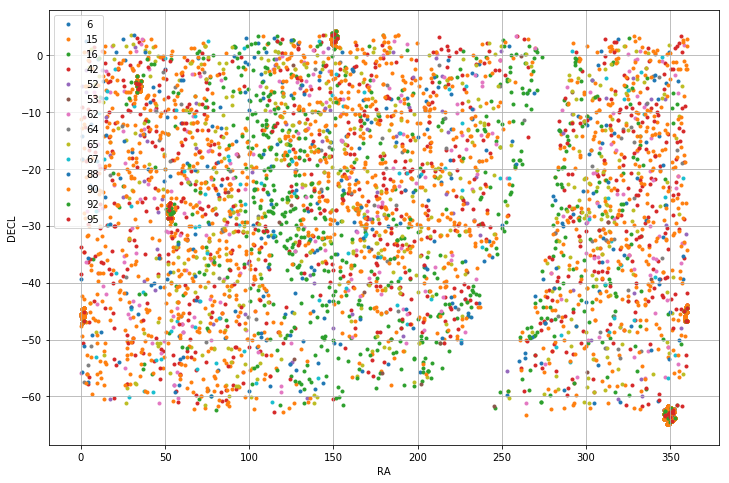

In [7]:
# Plot object by location in sky (Right Ascension and Declination) and colored by class

for target, df1 in df_train_meta.groupby('target'):
    plt.scatter(df1.ra, df1.decl, marker='.', label=target)
plt.grid()
plt.legend(loc='best')
plt.xlabel('RA')
plt.ylabel('DECL')
plt.show()

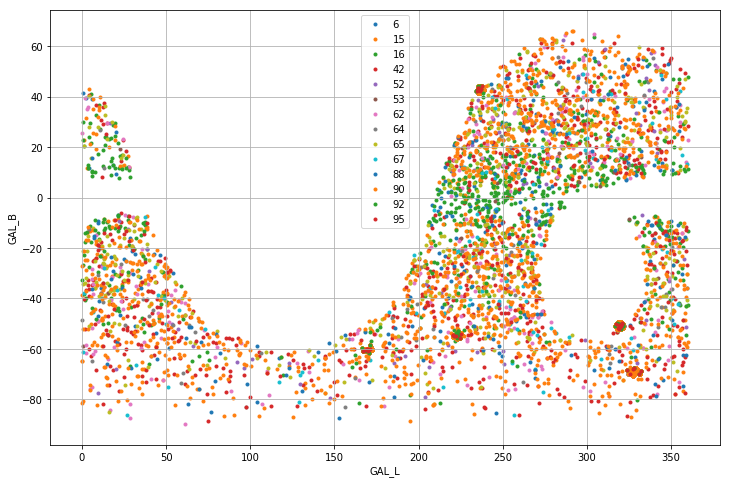

In [8]:
# Plot object by location (in Galactic coordinates) and colored by class

for target, df1 in df_train_meta.groupby('target'):
    plt.scatter(df1.gal_l, df1.gal_b, marker='.', label=target)
plt.grid()
plt.legend(loc='best')
plt.xlabel('GAL_L')
plt.ylabel('GAL_B')
plt.show()

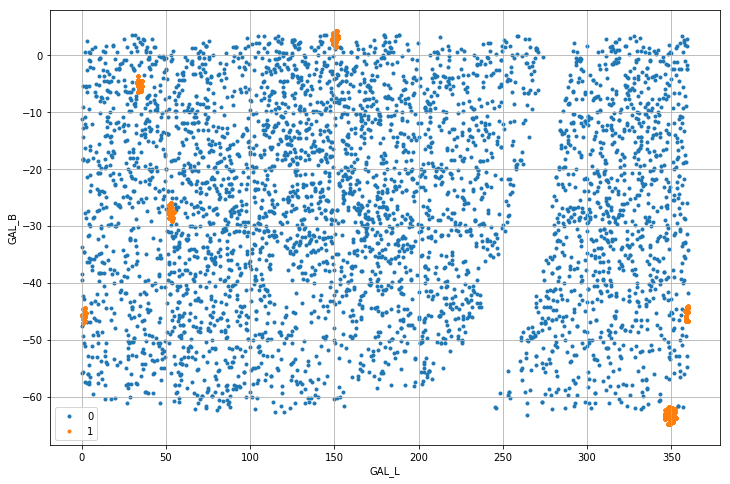

In [9]:
# Plot DDF

for ddf, df1 in df_train_meta.groupby('ddf'):
    plt.scatter(df1.ra, df1.decl, marker='.', label=ddf)
plt.grid()
plt.legend(loc='best')
plt.xlabel('GAL_L')
plt.ylabel('GAL_B')
plt.show()

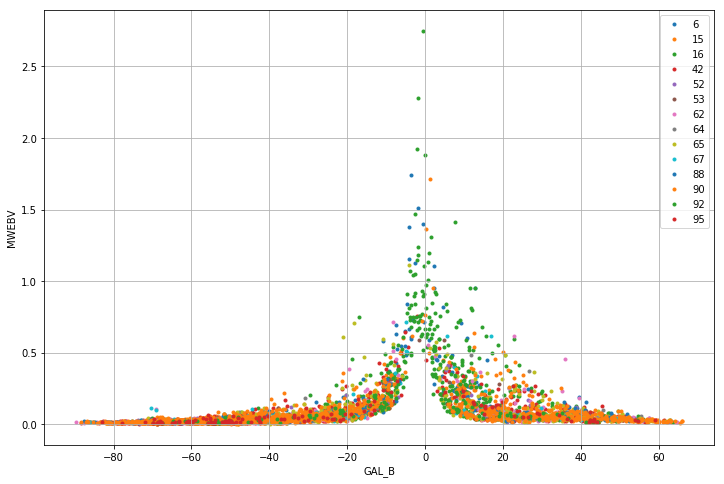

In [10]:
# Plot MWEBV ()

for target, df1 in df_train_meta.groupby('target'):
    plt.scatter(df1.gal_b, df1.mwebv, marker='.', label=target)
plt.grid()
plt.legend(loc='best')
plt.xlabel('GAL_B')
plt.ylabel('MWEBV')
plt.show()

### Crosstabs

In [11]:
pd.crosstab(df_train_meta.ddf, df_train_meta.target)

target   6    15   16   42  52  53   62  64   65   67   88    90   92  95
ddf                                                                      
0       107  356  593  674  86  19  258  75  498  105  197  1097  135  96
1         3    7  132  223  57   3   95   2  236   49   87   623   40  33

In [12]:
pd.crosstab(df_train_meta.hostgal_photoz > 0, df_train_meta.target)

target           6    15   16   42   52  53   62  64   65   67   88    90  \
hostgal_photoz                                                              
False           110    0  725    0    0  22    0   0  734    0    0     0   
True              0  363    0  897  143   0  353  77    0  154  284  1720   

target           92   95  
hostgal_photoz            
False           175    0  
True              0  129

In [13]:
pd.crosstab(df_train_meta.hostgal_photoz > 0, df_train_meta.hostgal_specz > 0)

hostgal_specz   False  True 
hostgal_photoz              
False            1766      0
True                0   4120

### Timeseries

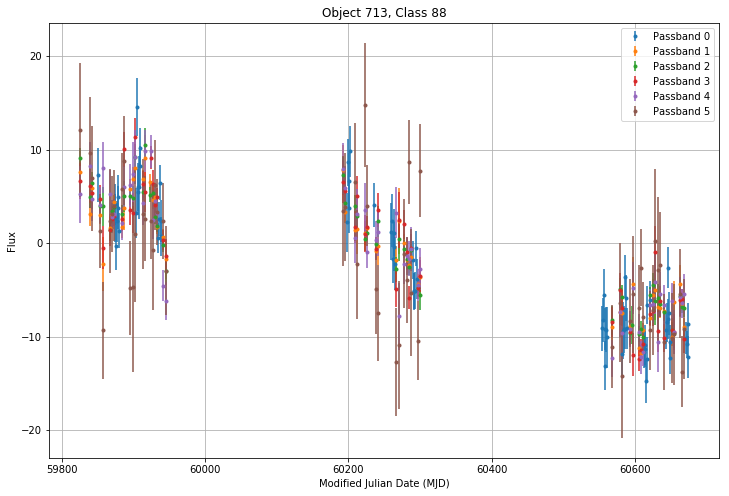

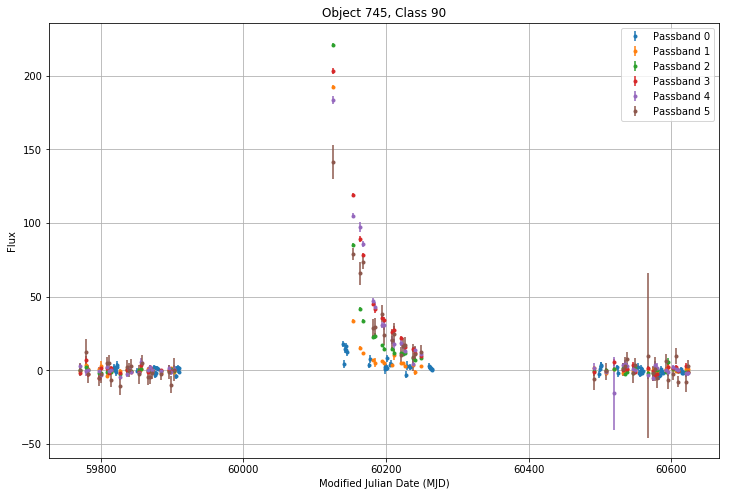

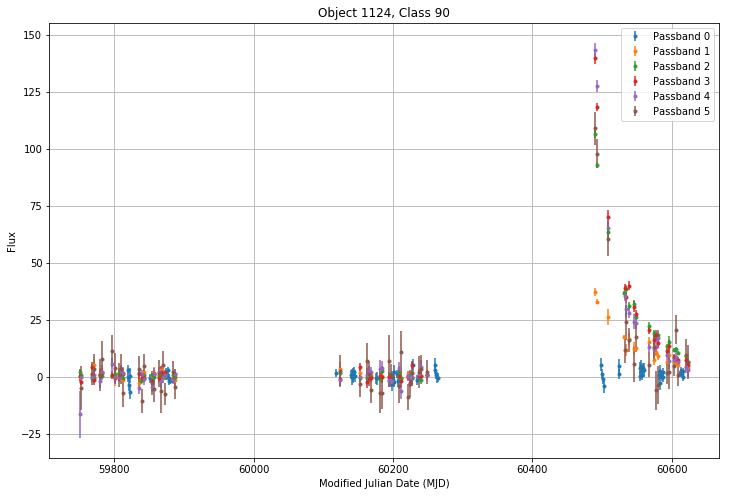

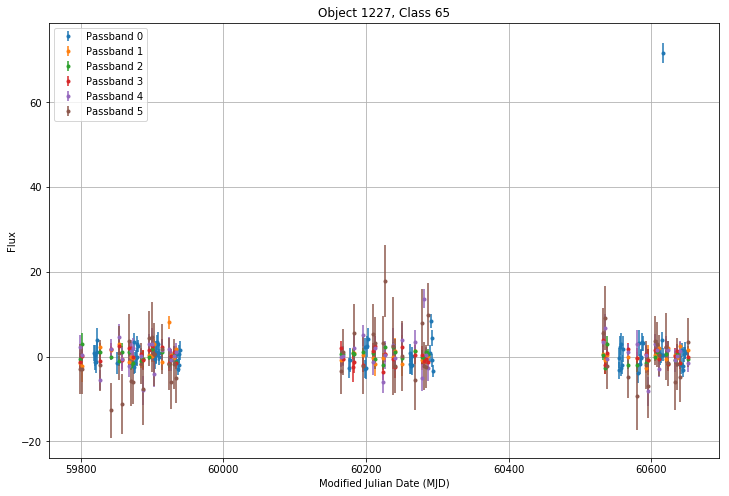

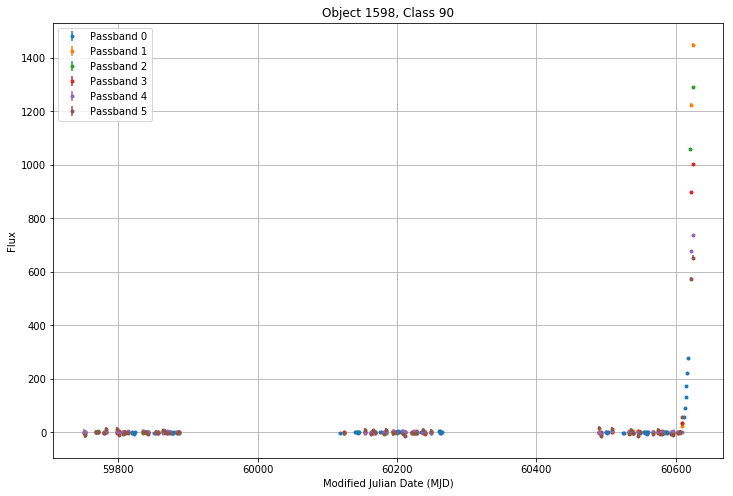

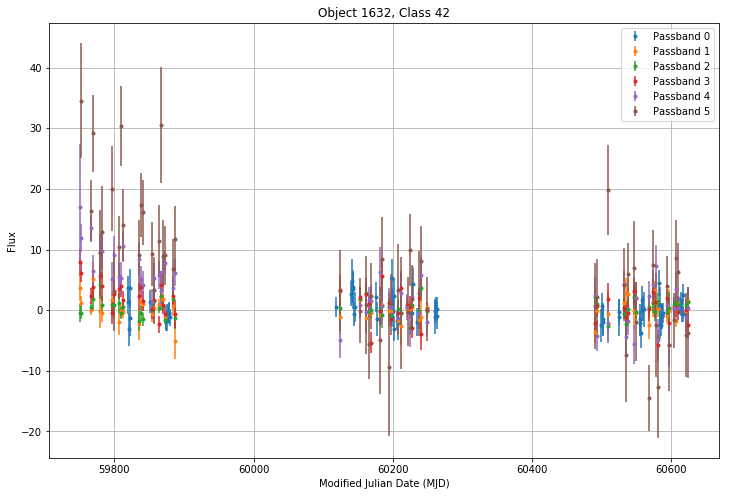

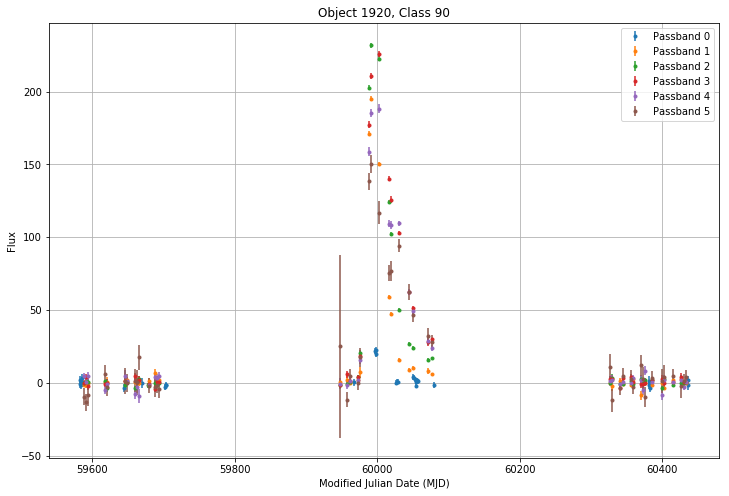

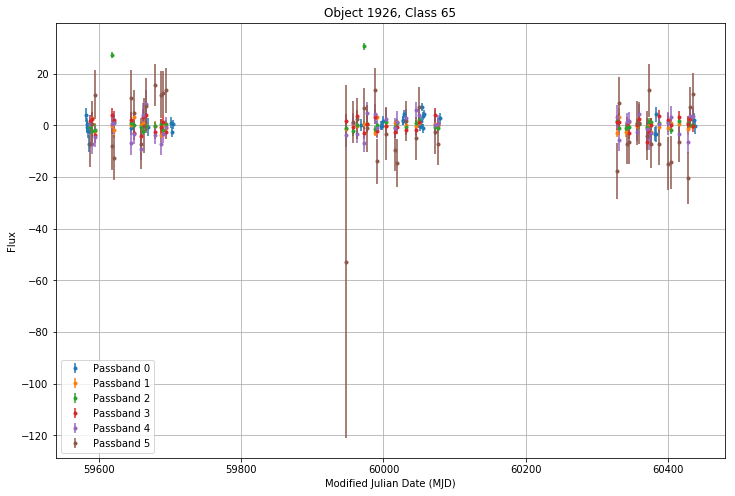

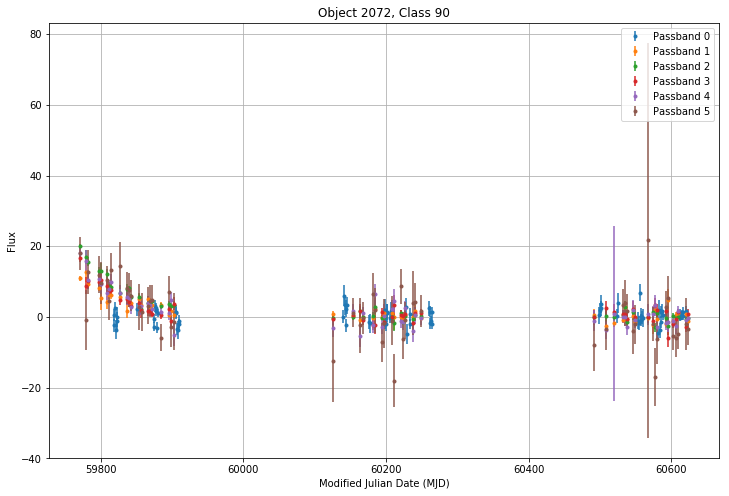

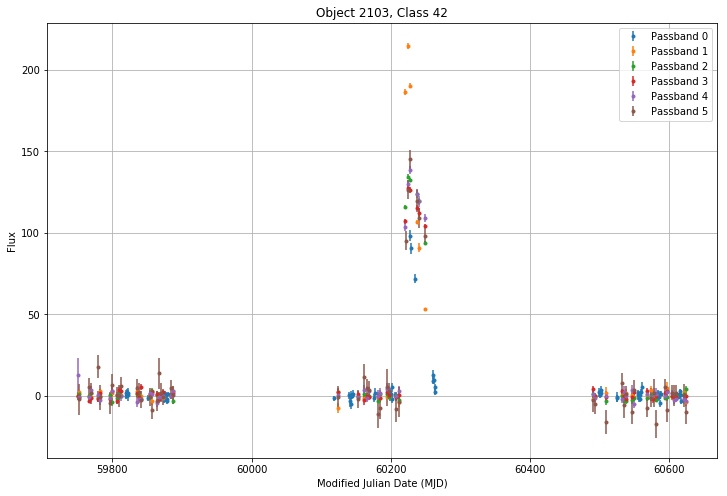

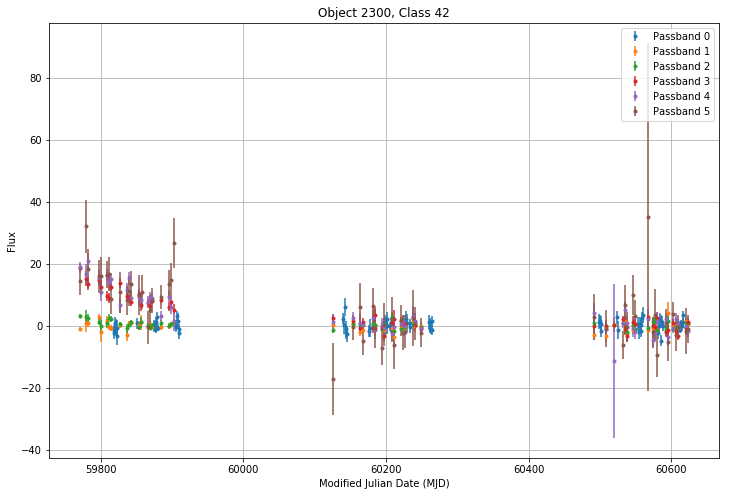

In [14]:
# Plot some examples of the time series data

graph_count = 0
for object_id, df1 in df_train.groupby('object_id'):
    metadata = df_train_meta[df_train_meta.object_id == object_id]
    for passband, df2 in df1.groupby('passband'):
        plt.errorbar(df2.mjd, df2.flux, yerr=df2.flux_err, fmt='.',
                     label='Passband {}'.format(passband))
    
    plt.grid()
    plt.legend(loc='best')
    plt.title('Object {}, Class {}'.format(object_id, int(metadata.target)))
    plt.xlabel('Modified Julian Date (MJD)')
    plt.ylabel('Flux')
    plt.show()
    
    if graph_count == 10:
        break
    graph_count += 1

Object 713, Class 88


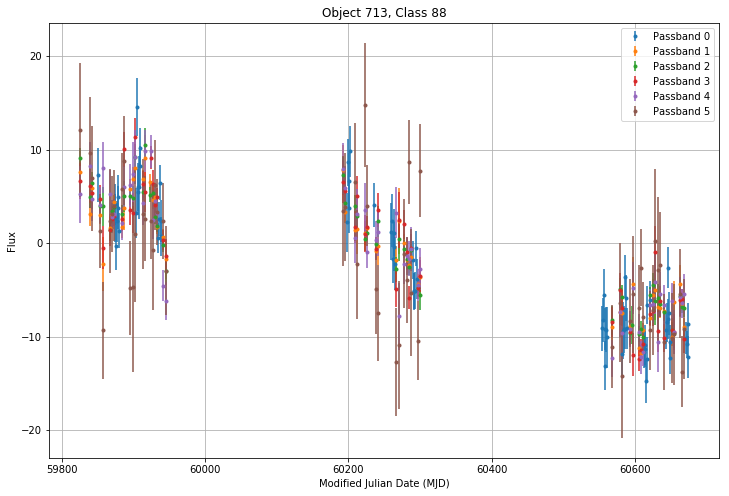

Object 745, Class 90


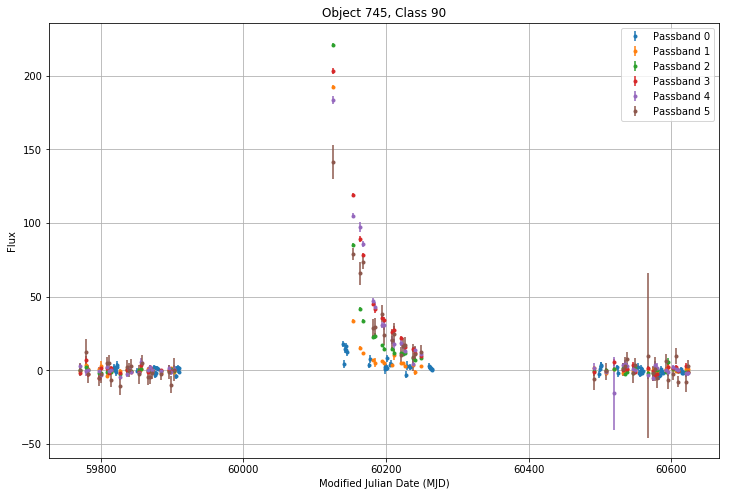

Object 1124, Class 90


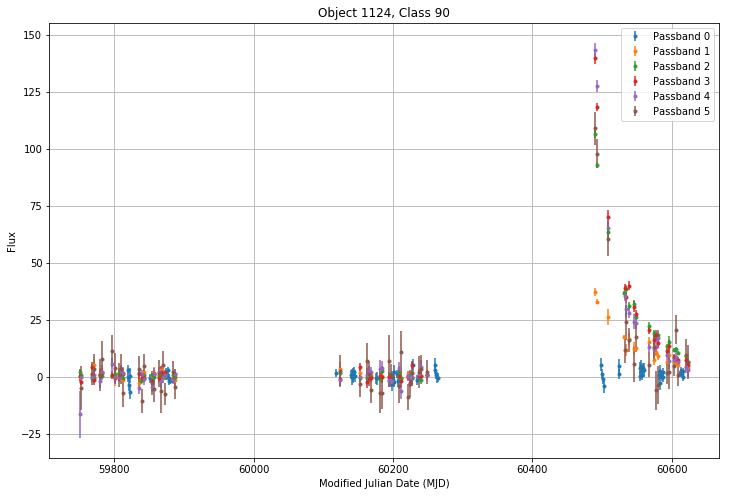

Object 1227, Class 65


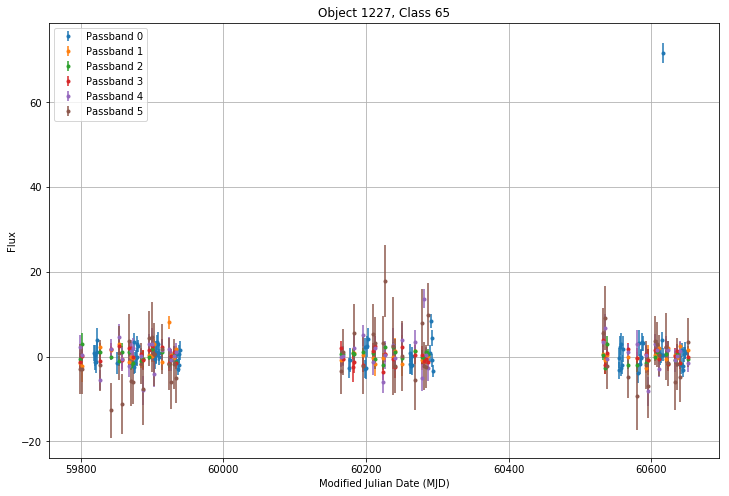

Object 1598, Class 90


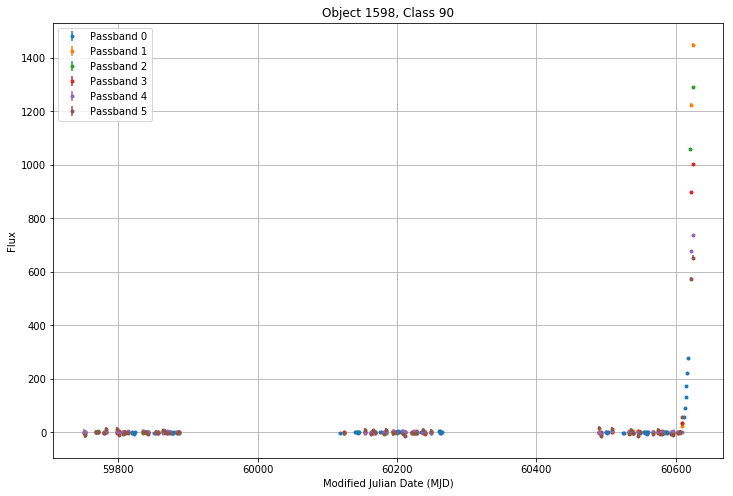

Object 1632, Class 42


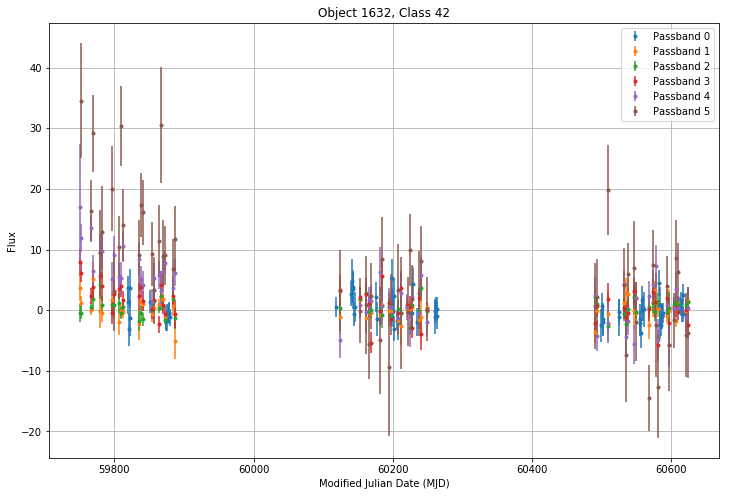

Object 1920, Class 90


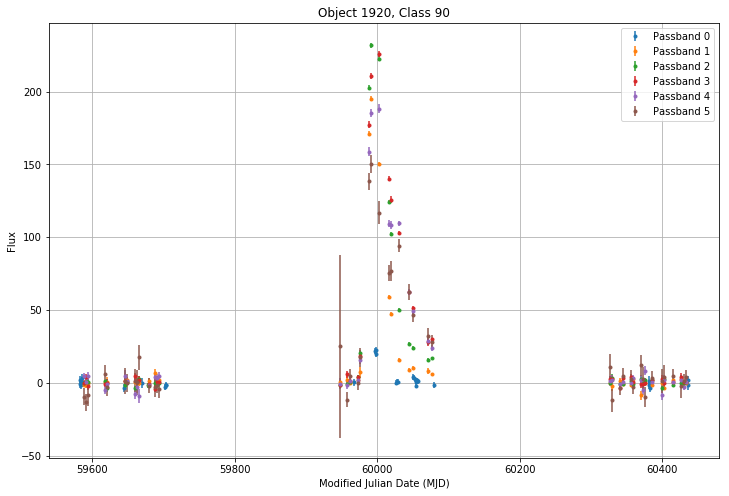

Object 1926, Class 65


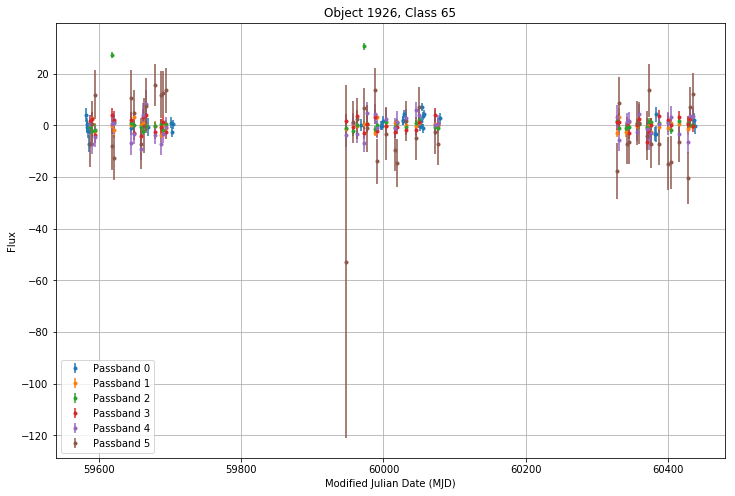

Object 2072, Class 90


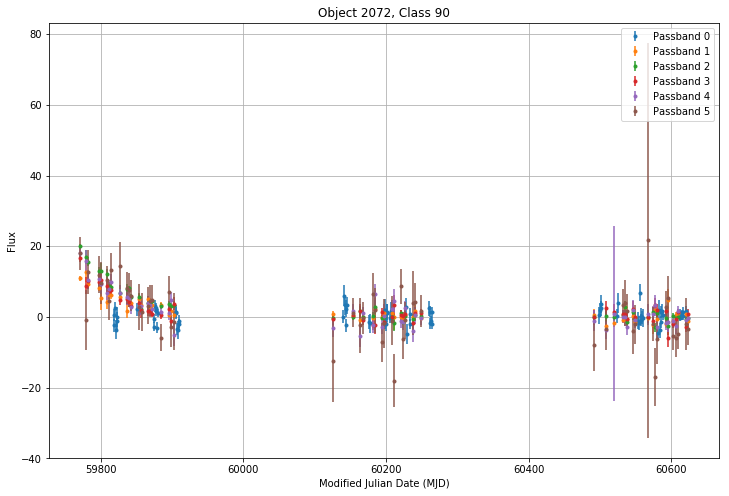

Object 2103, Class 42


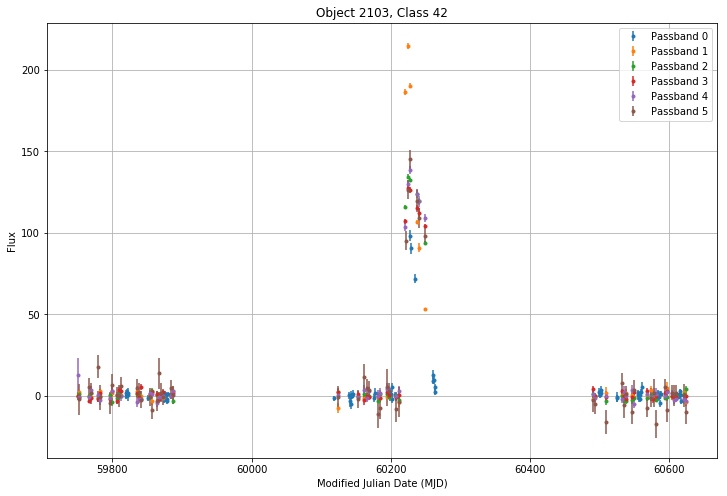

Object 2300, Class 42


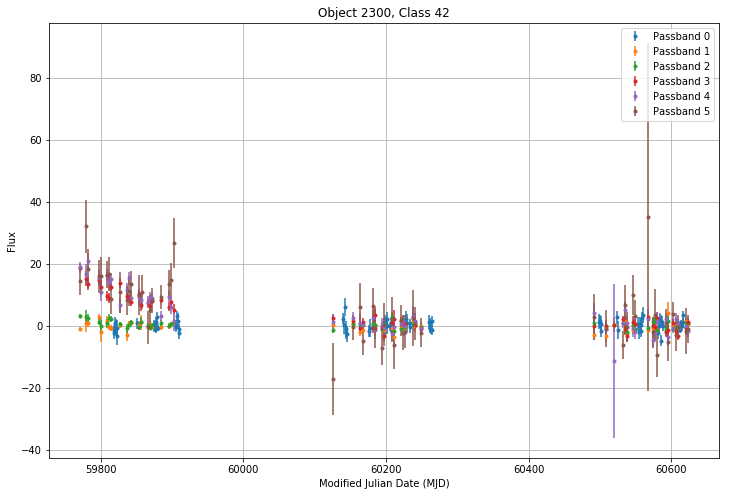

Object 2922, Class 67


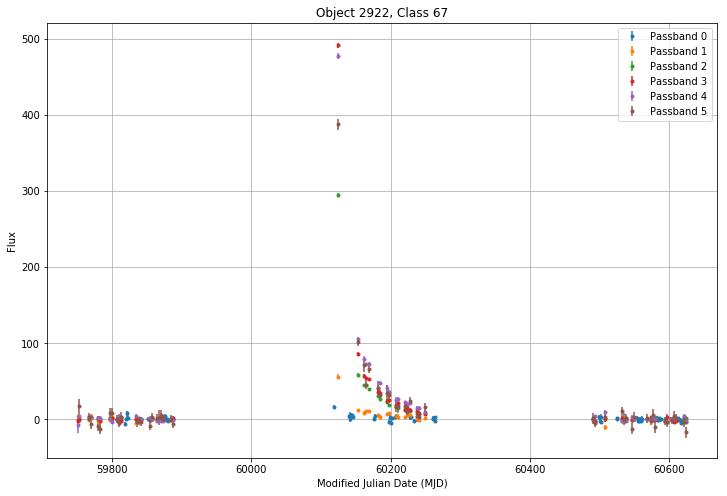

Object 3041, Class 67


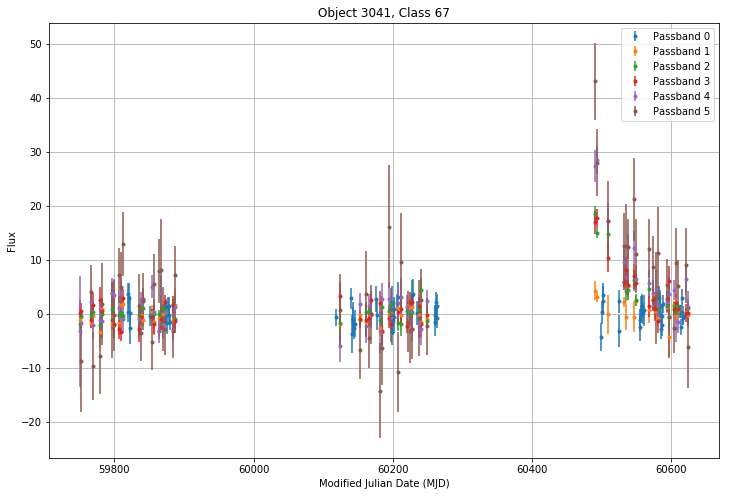

Object 3423, Class 95


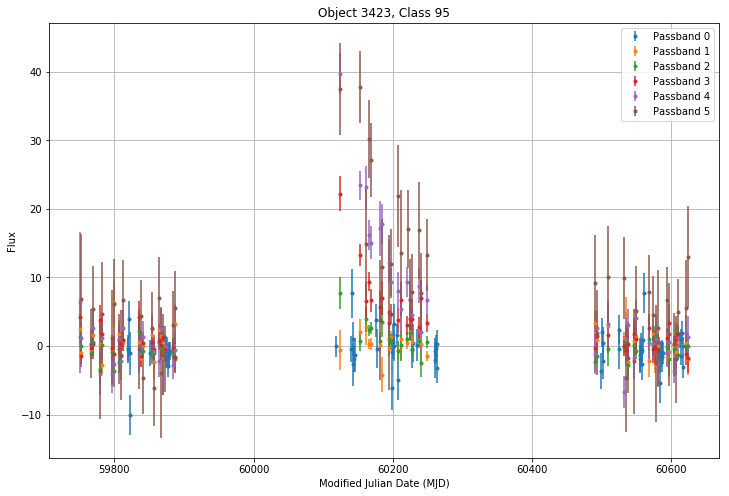

Object 3910, Class 62


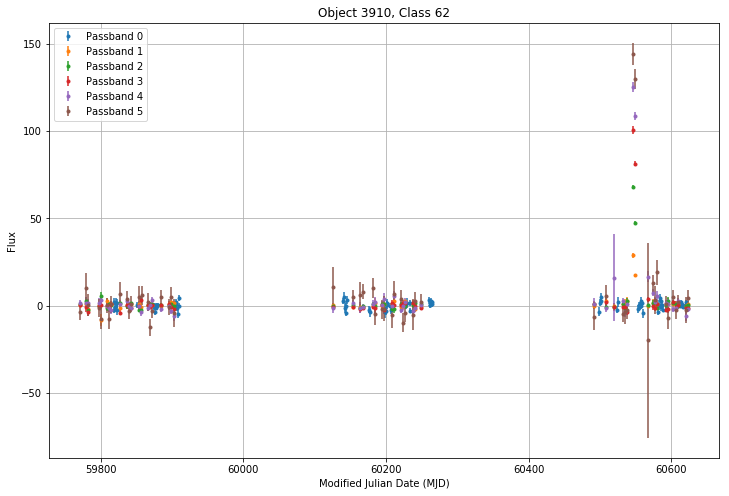

Object 4088, Class 88


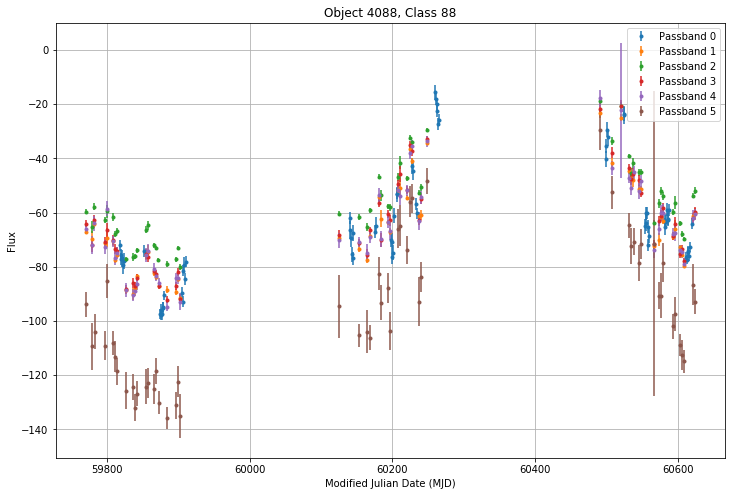

Object 4132, Class 42


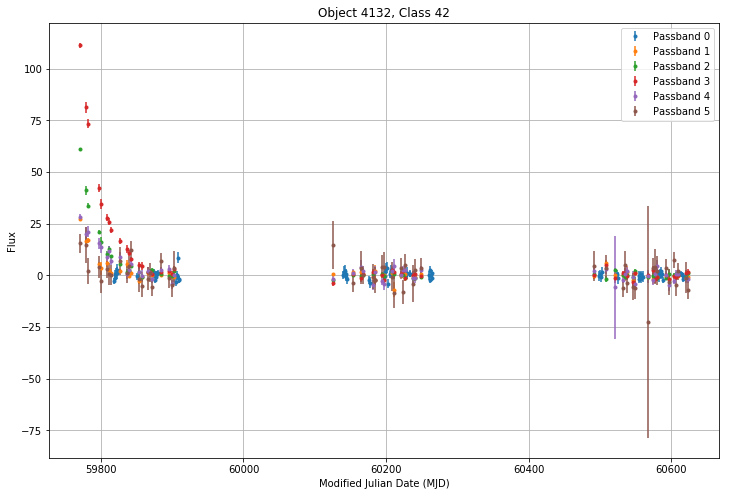

Object 4171, Class 16


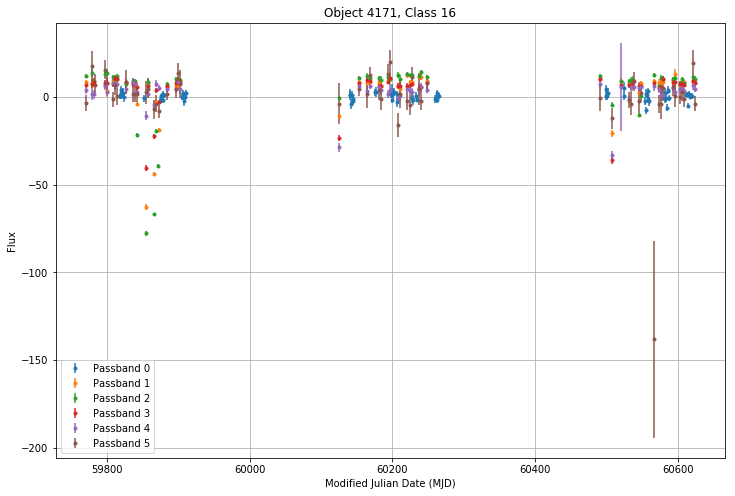

Object 4173, Class 15


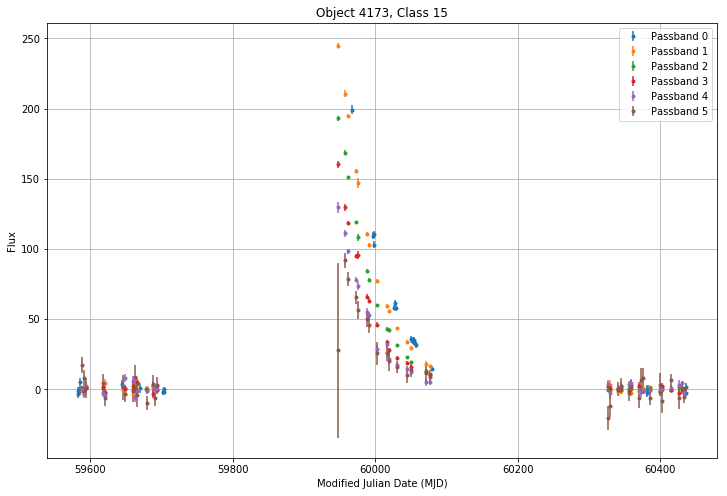

Object 4220, Class 42


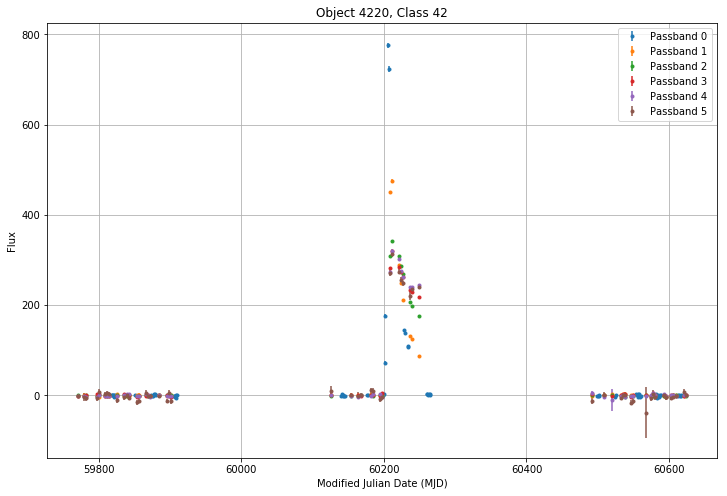

Object 6266, Class 65


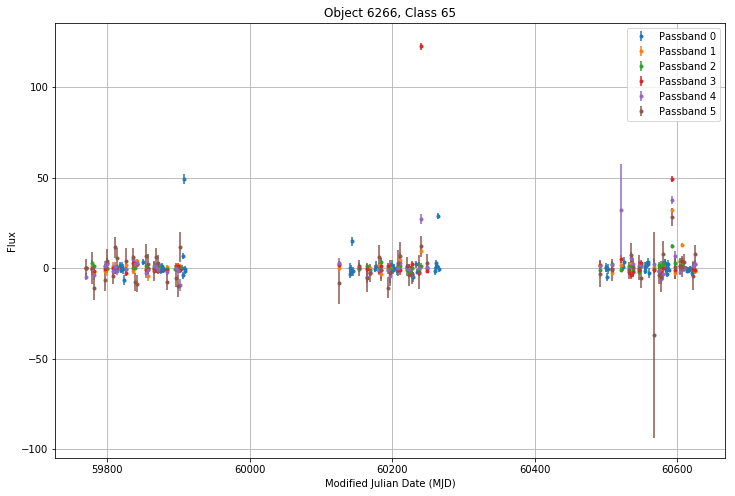

Object 7315, Class 88


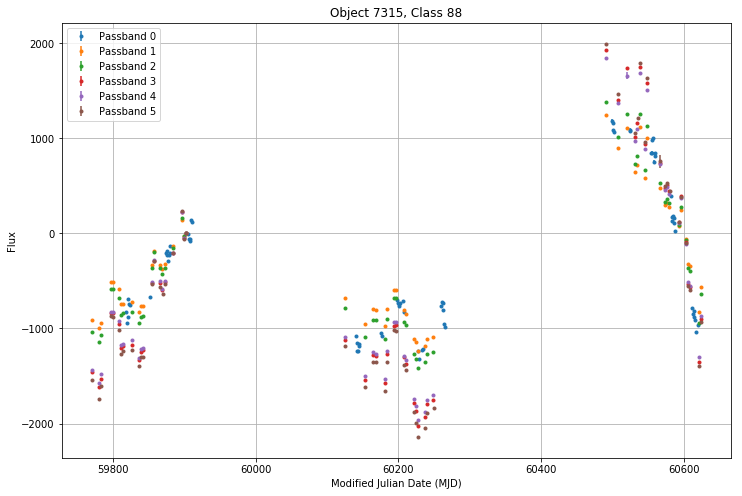

Object 7409, Class 88


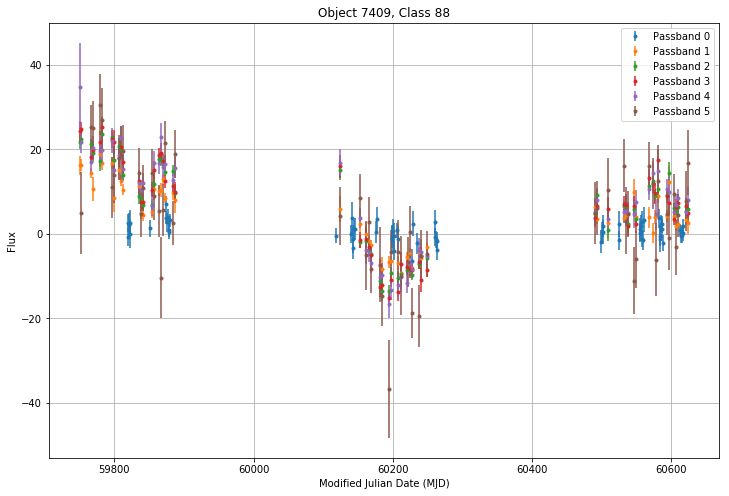

Object 7566, Class 16


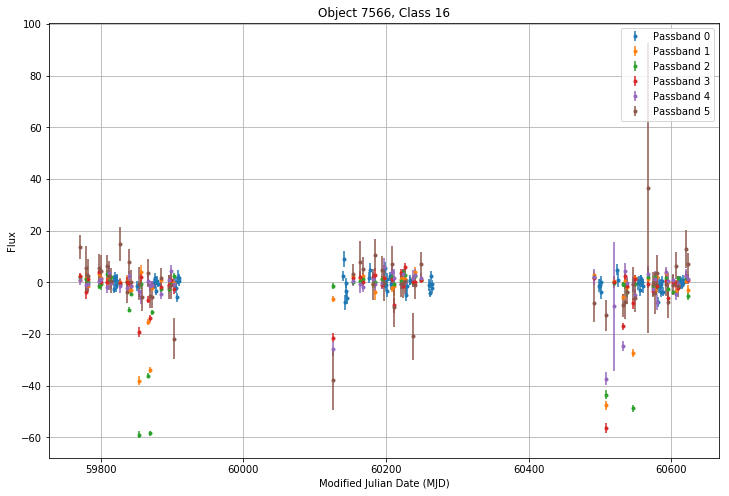

Object 7703, Class 62


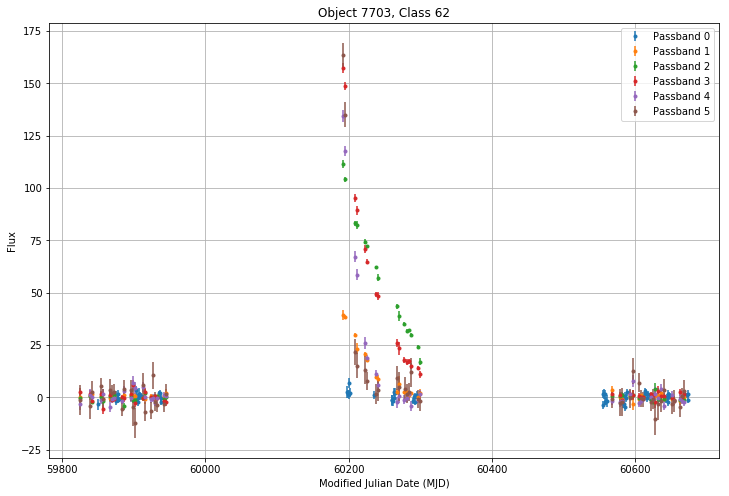

Object 8688, Class 65


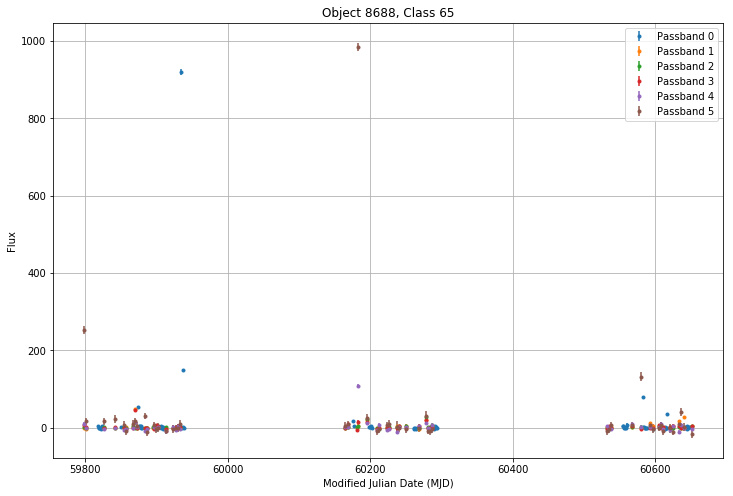

Object 9006, Class 65


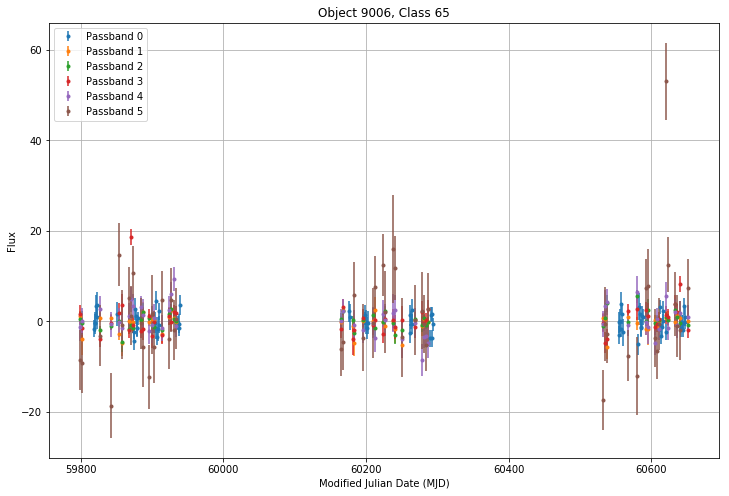

Object 10321, Class 95


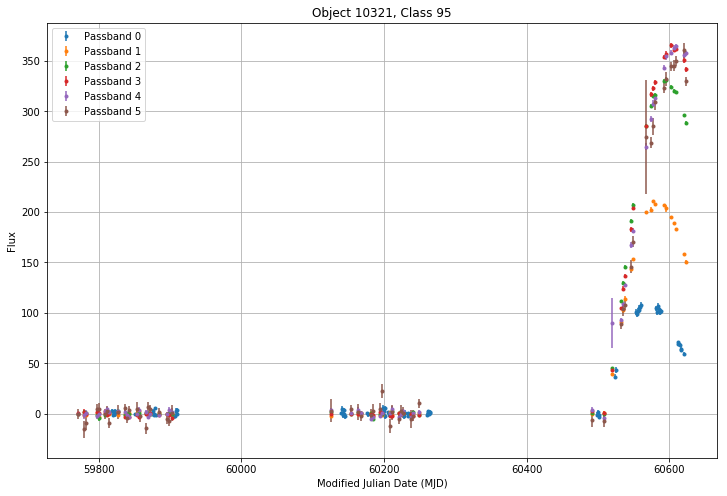

Object 10586, Class 88


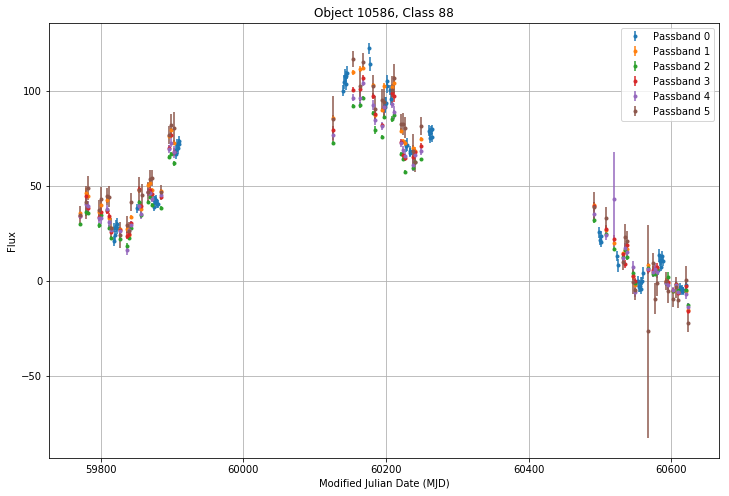

Object 11165, Class 16


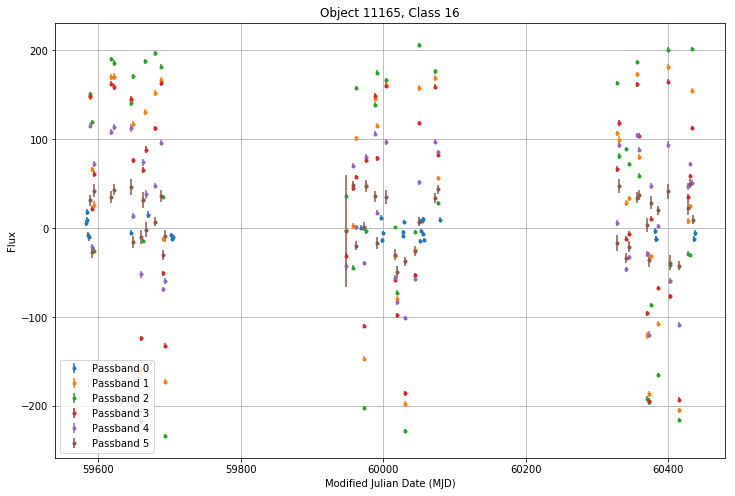

Object 11770, Class 62


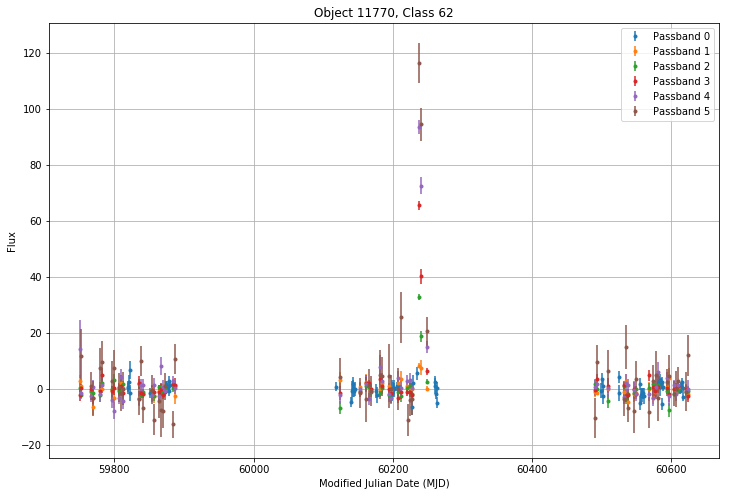

Object 11773, Class 52


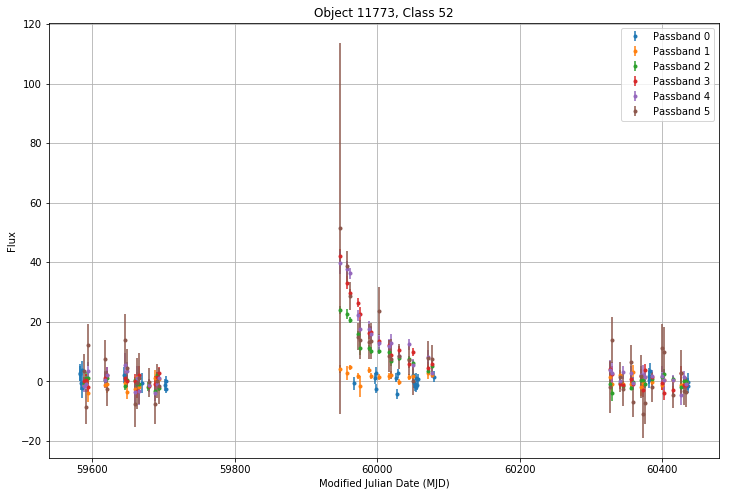

Object 13138, Class 52


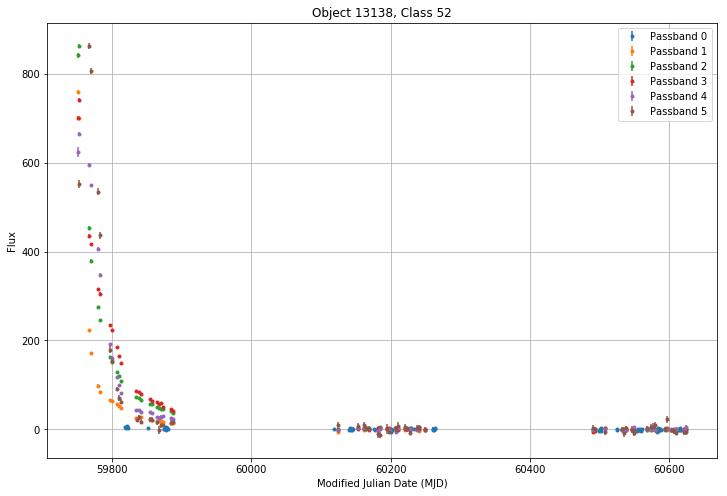

Object 14279, Class 52


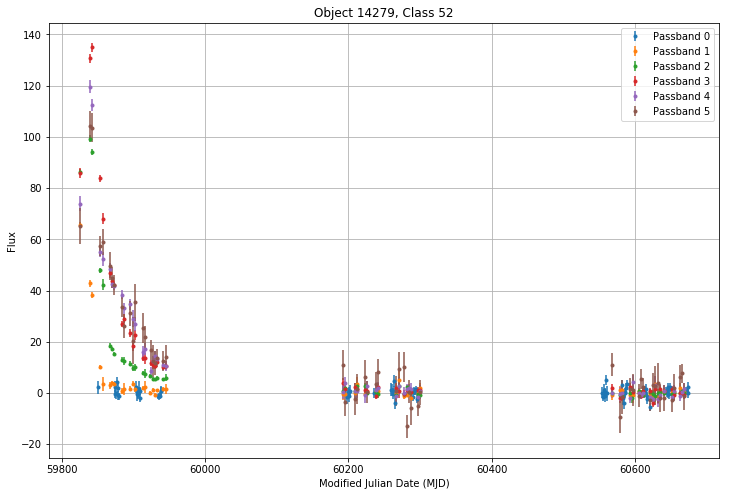

Object 14553, Class 95


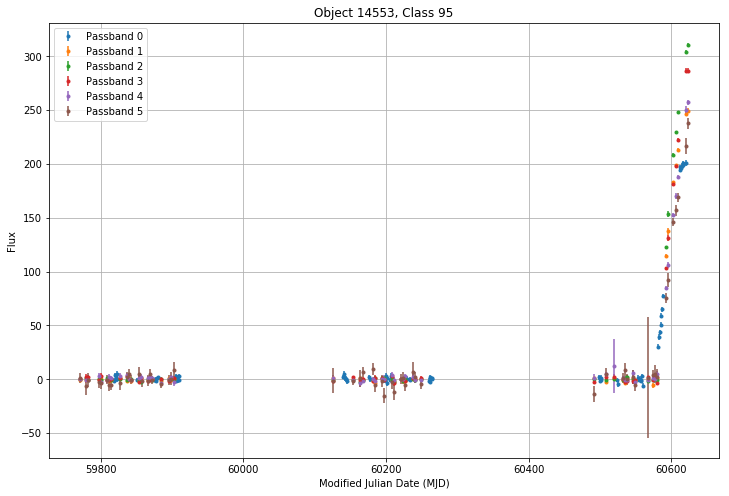

Object 15626, Class 16


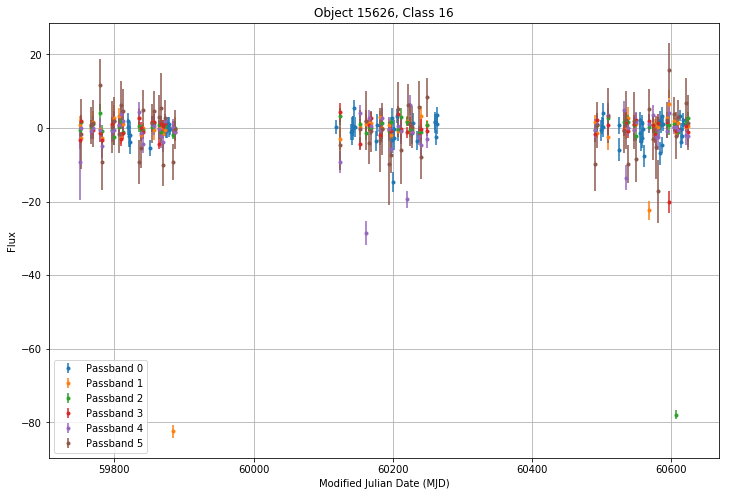

Object 15700, Class 16


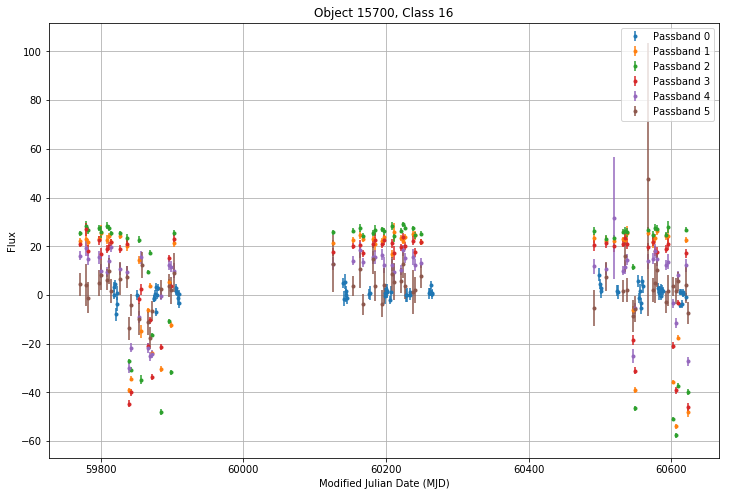

Object 15718, Class 52


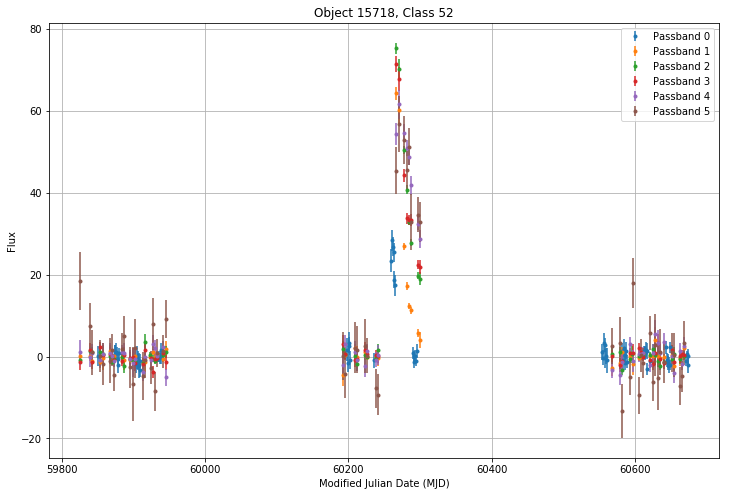

Object 16496, Class 52


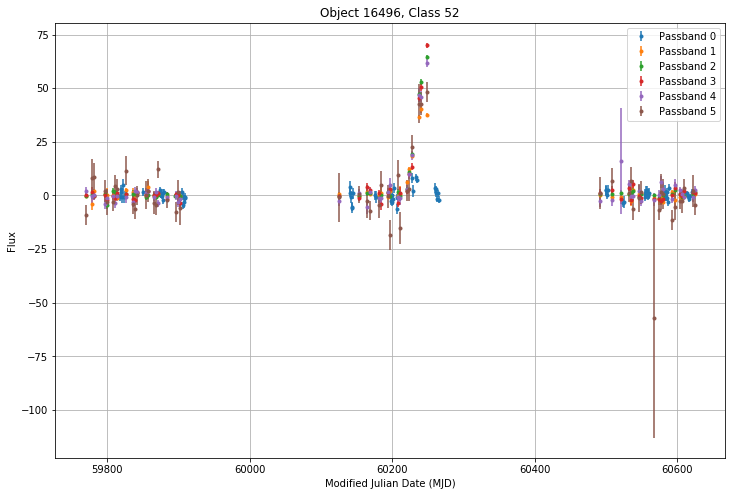

Object 18645, Class 62


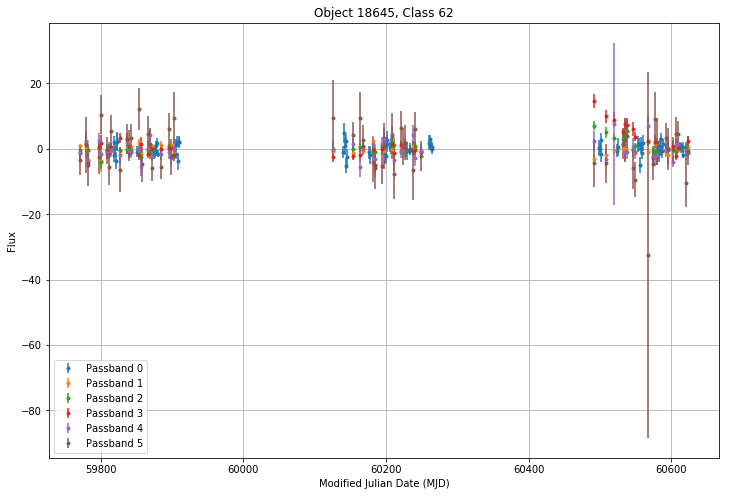

Object 18706, Class 62


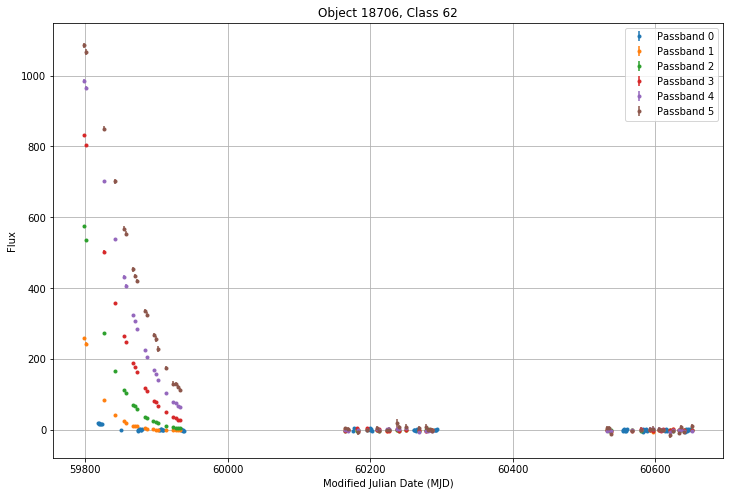

Object 23116, Class 15


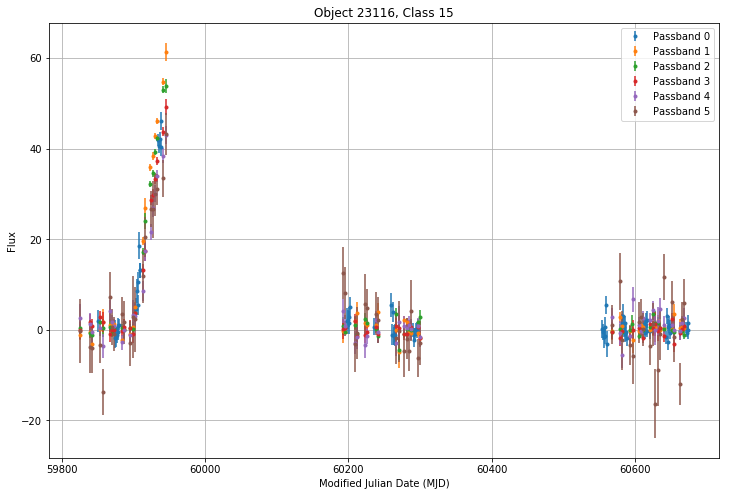

Object 23539, Class 95


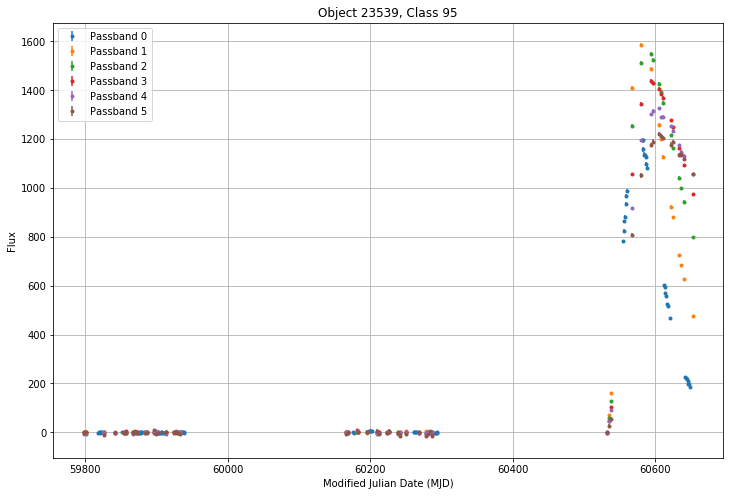

Object 31569, Class 95


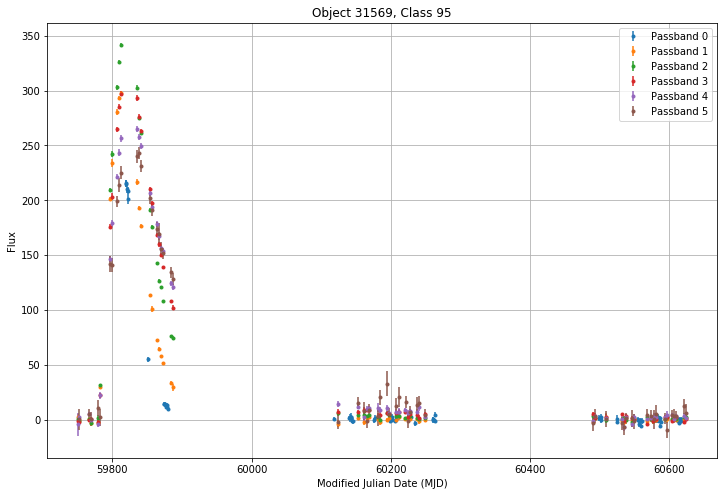

Object 34437, Class 67


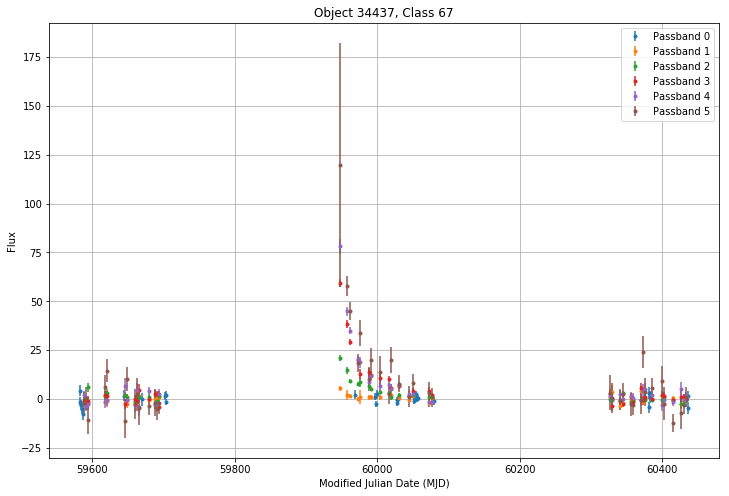

Object 37872, Class 67


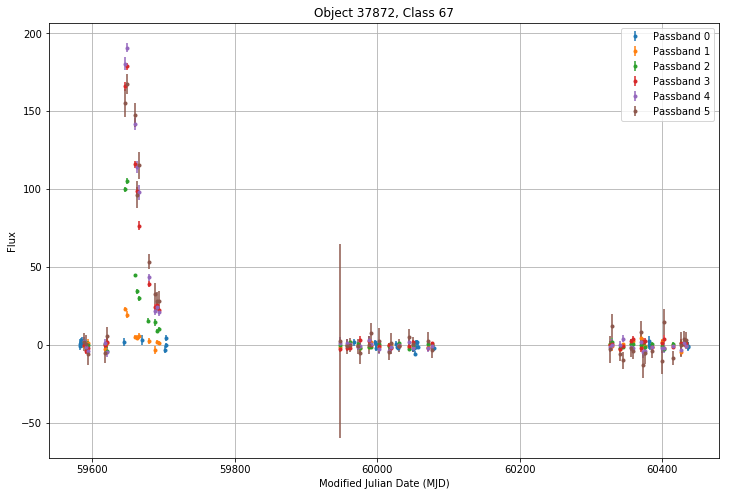

Object 42333, Class 67


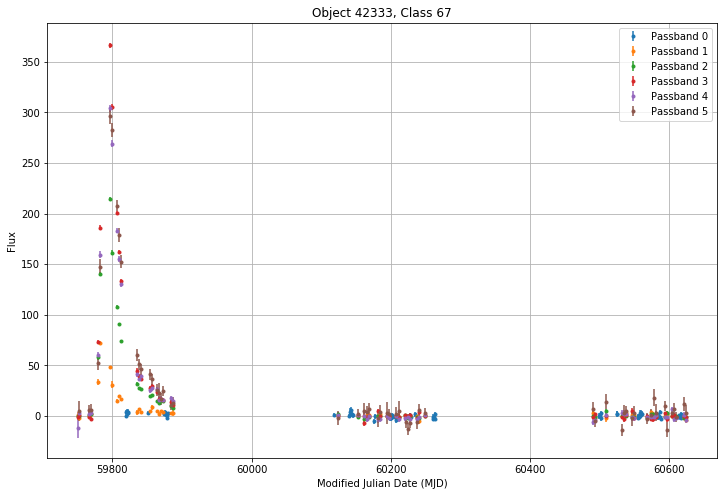

Object 51987, Class 92


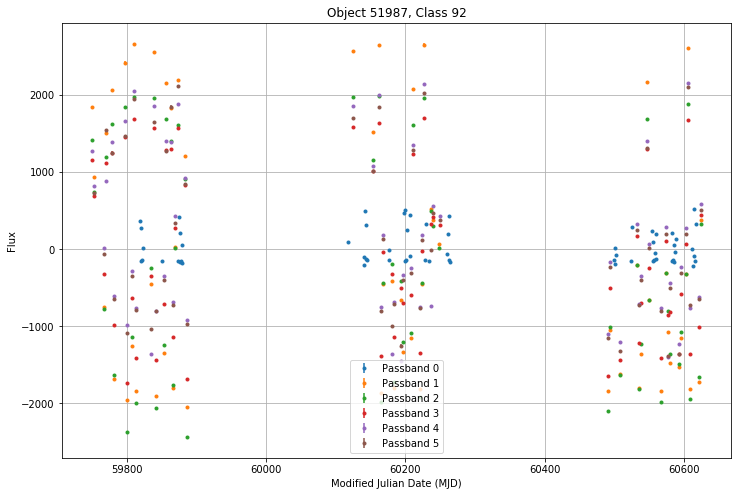

Object 61407, Class 92


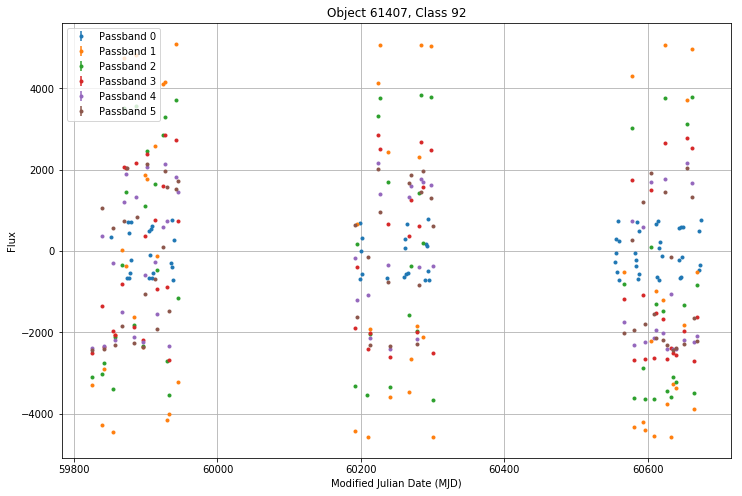

Object 62187, Class 64


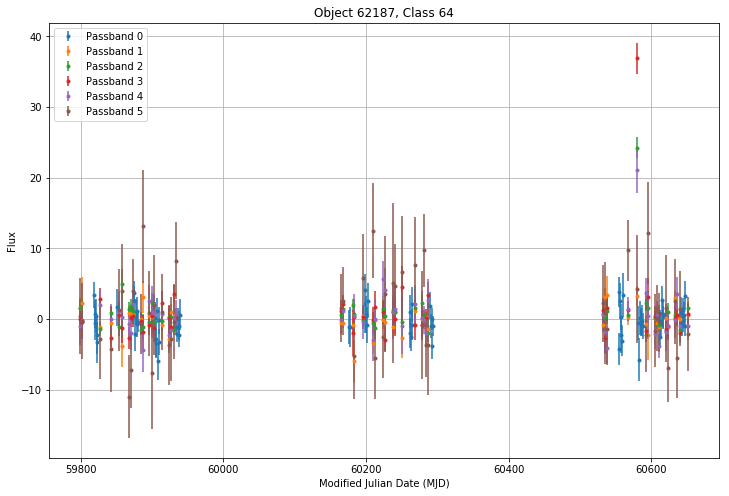

Object 78702, Class 92


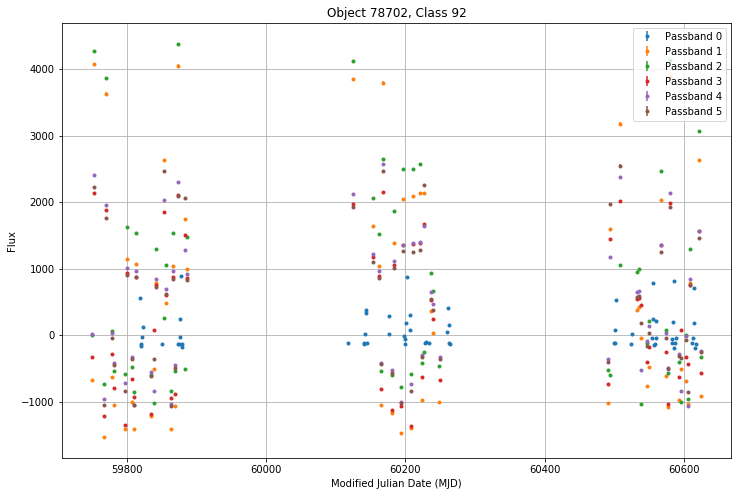

Object 78705, Class 92


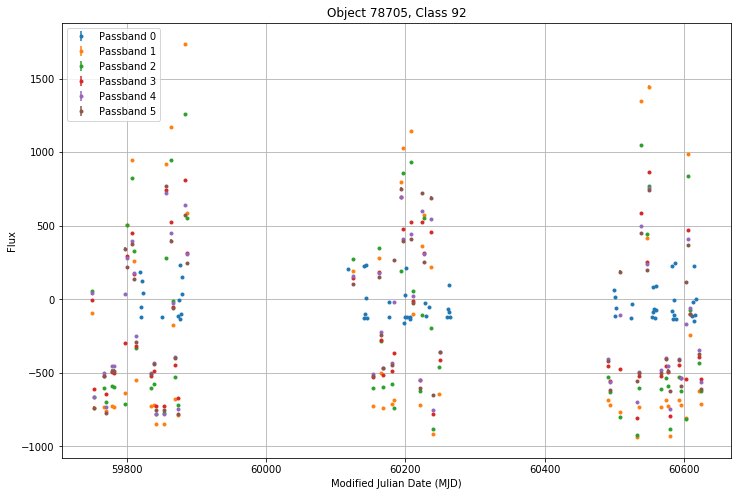

Object 88073, Class 92


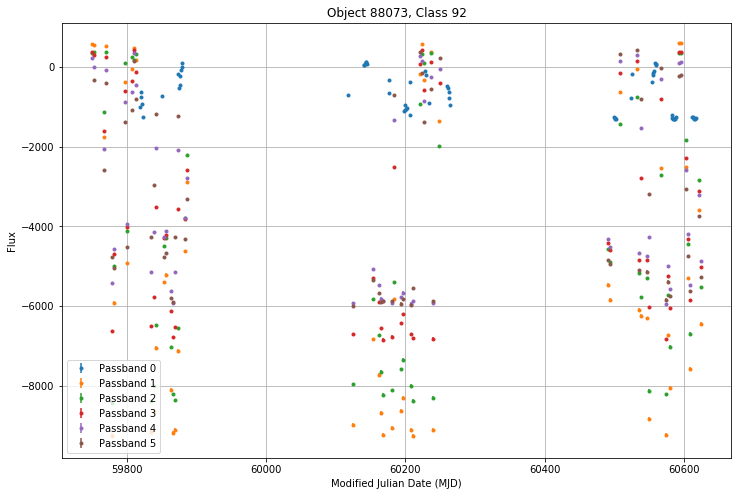

Object 97406, Class 15


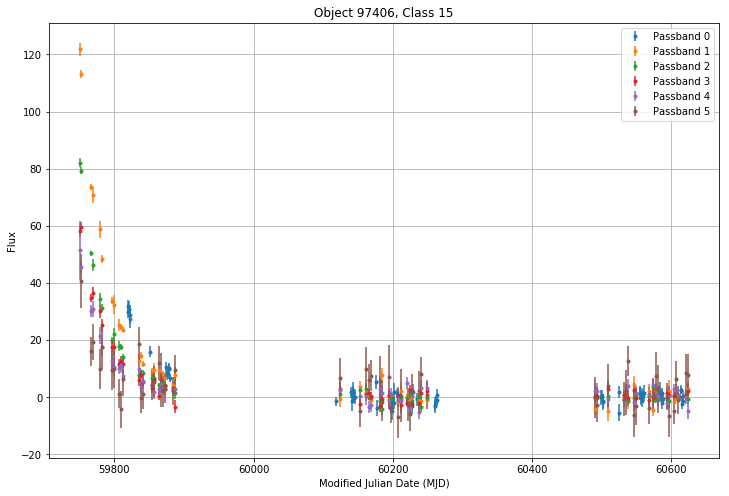

Object 113669, Class 15


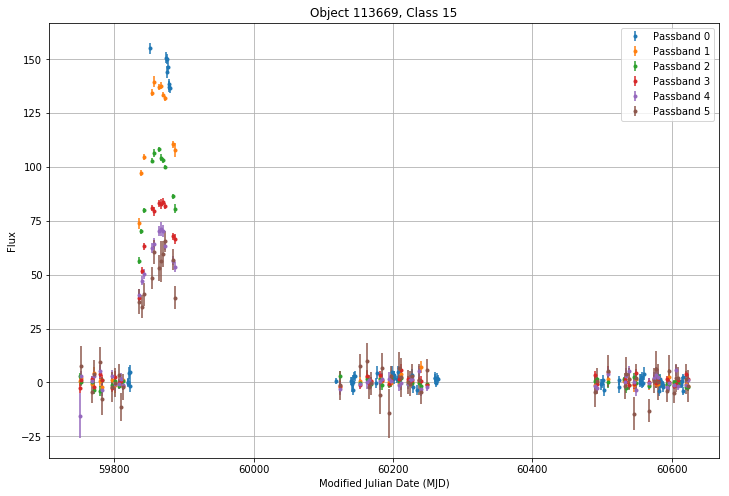

Object 133234, Class 15


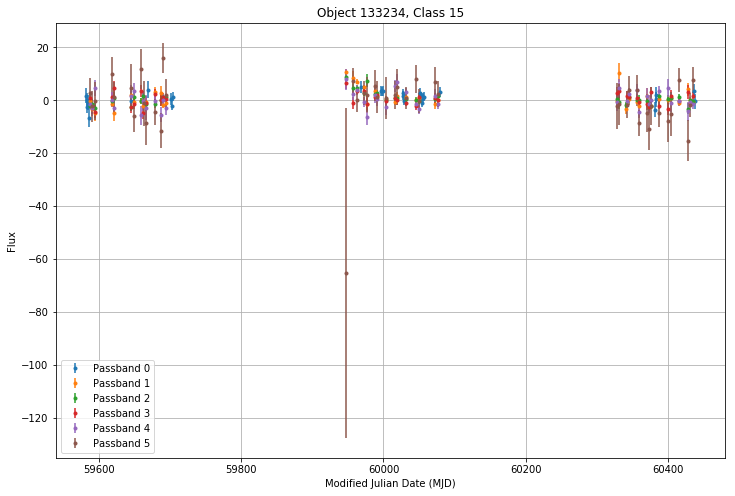

Object 139362, Class 64


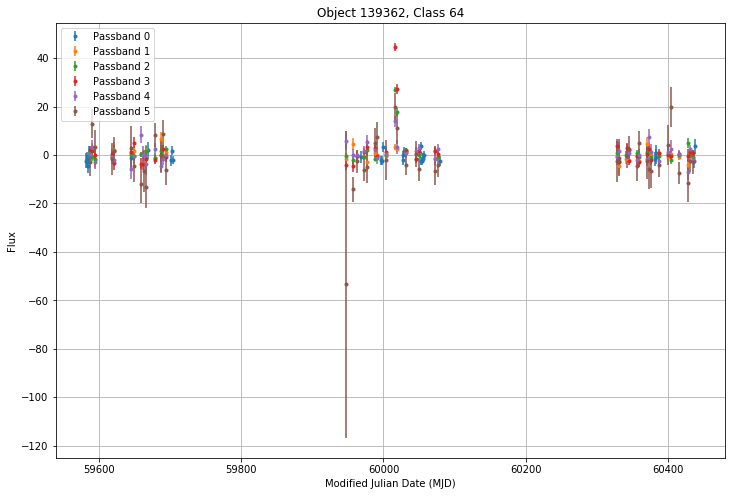

Object 201890, Class 6


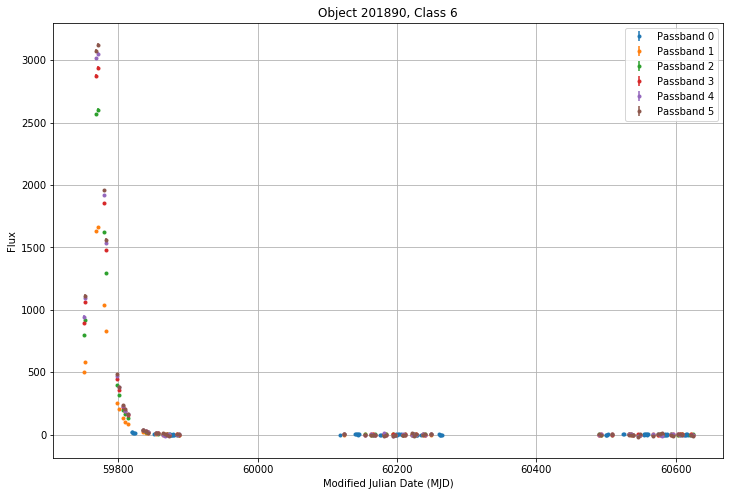

Object 268977, Class 53


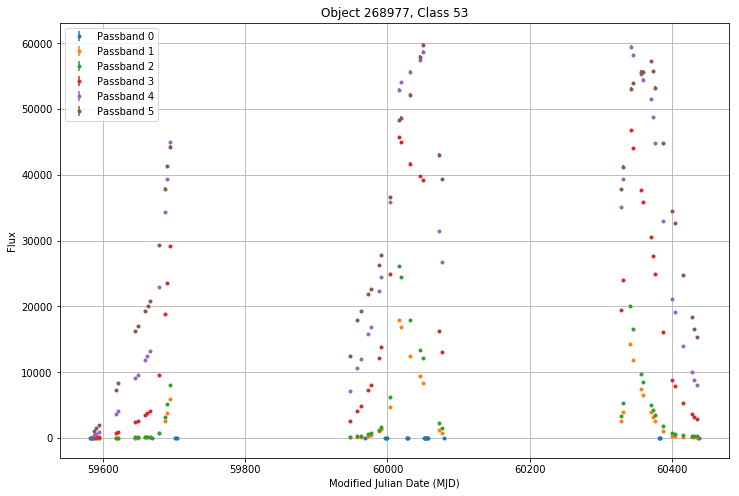

Object 278480, Class 53


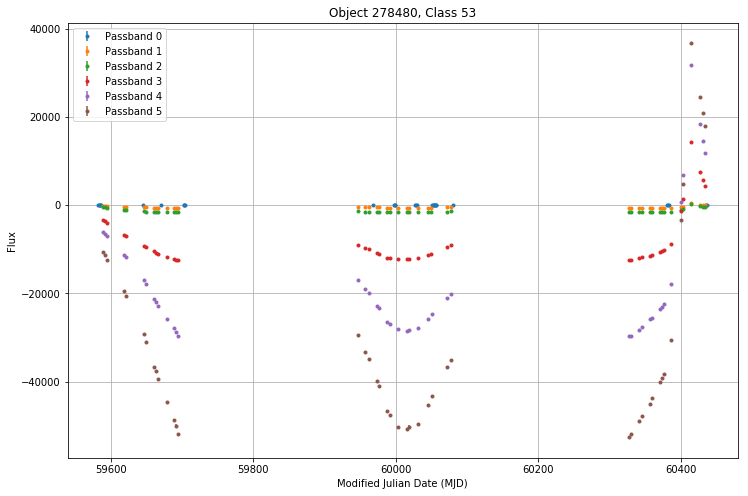

Object 282647, Class 6


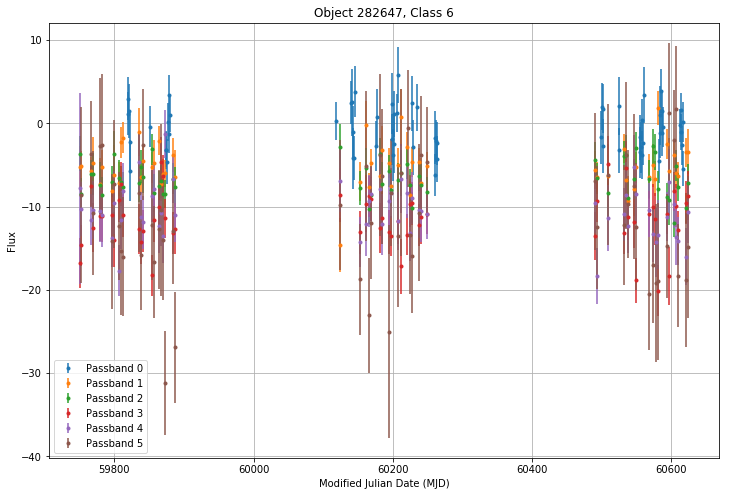

Object 288194, Class 53


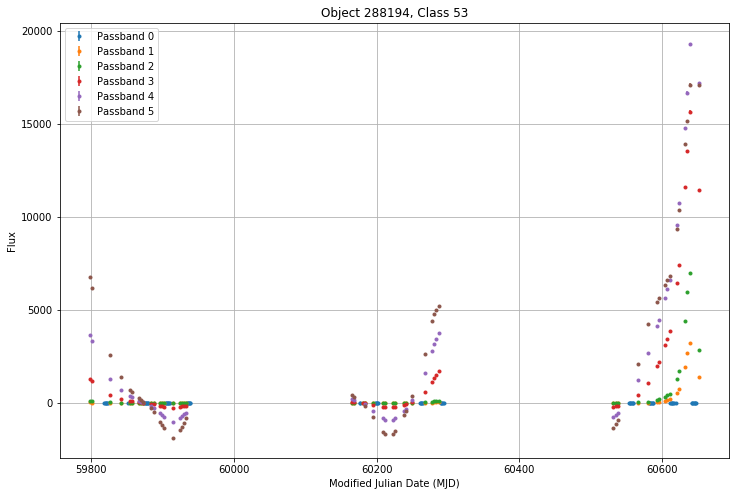

Object 332684, Class 6


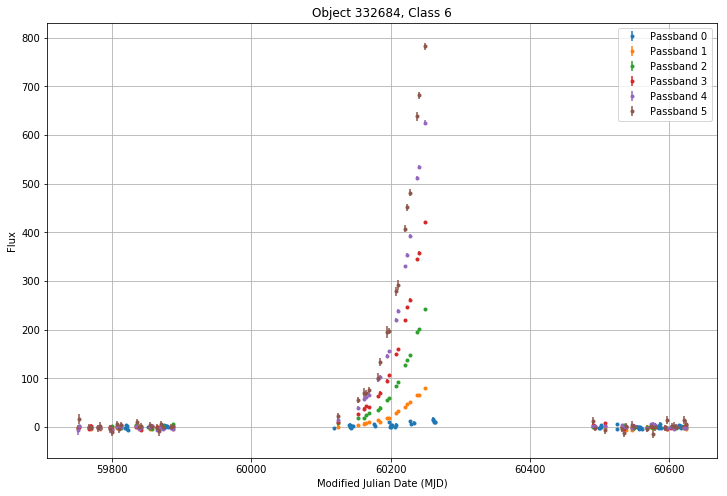

Object 1497514, Class 6


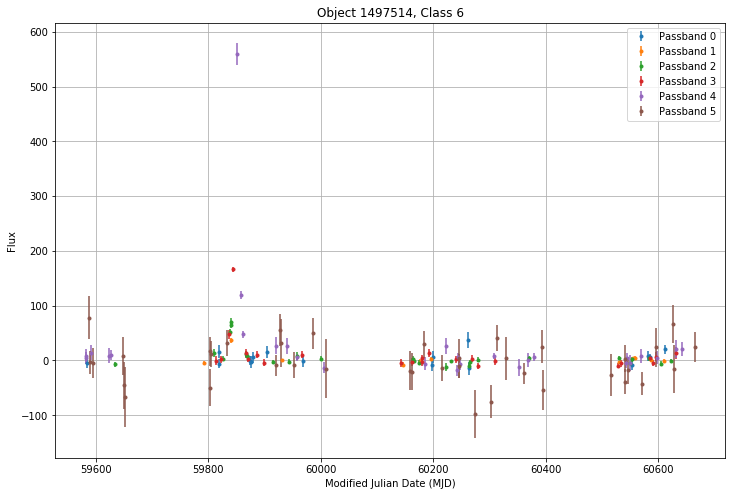

Object 1516088, Class 6


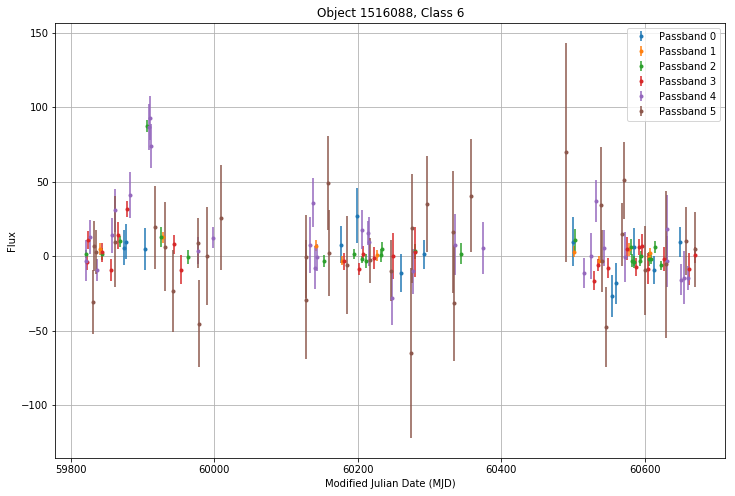

Object 3572446, Class 64


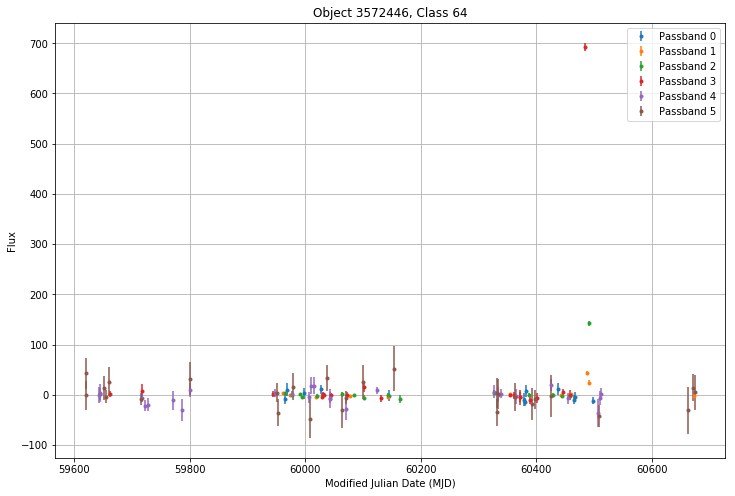

Object 4311960, Class 64


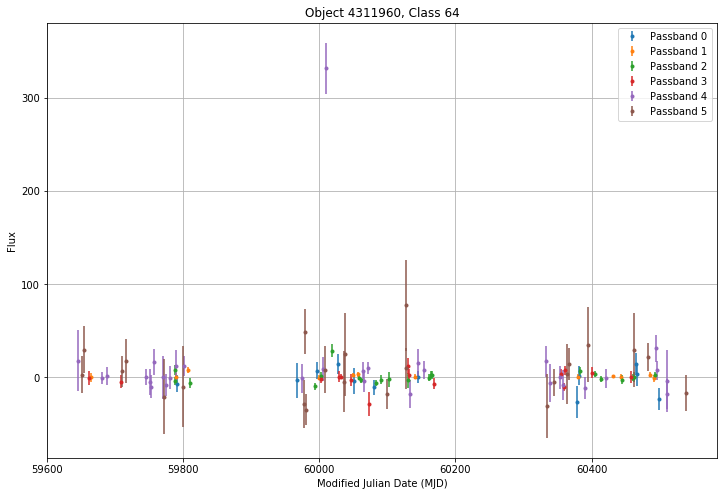

Object 4416529, Class 53


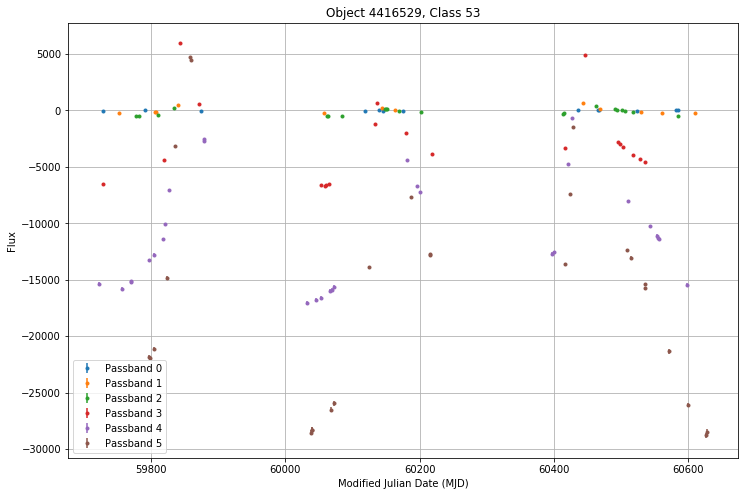

Object 4539153, Class 64


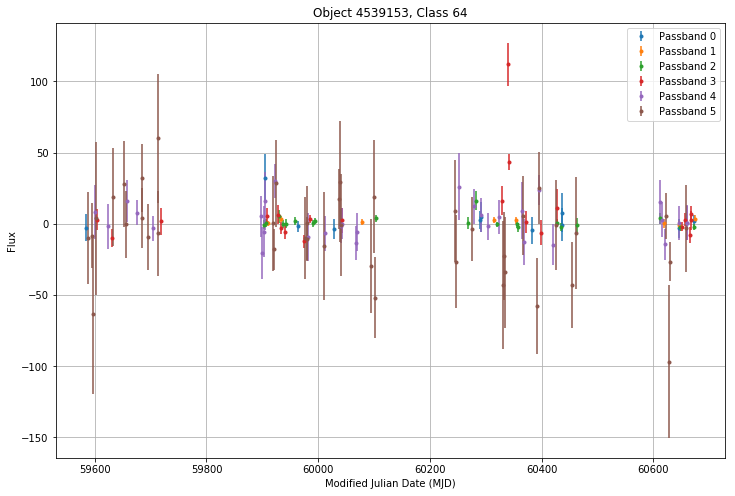

Object 16504681, Class 53


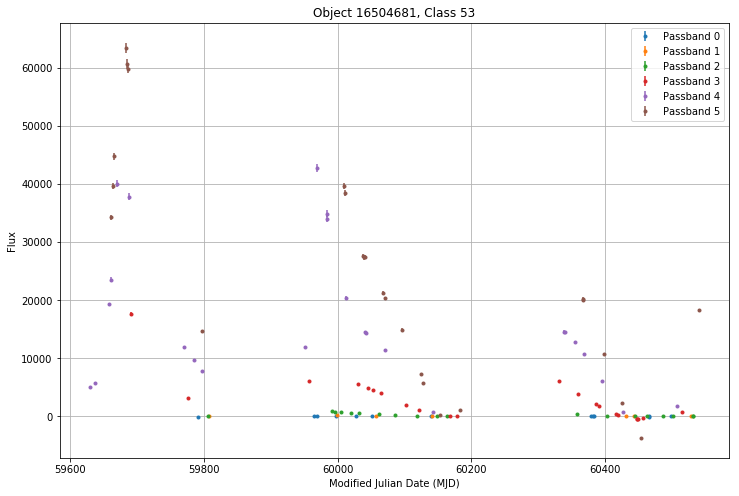

CPU times: user 27.5 s, sys: 2.12 s, total: 29.6 s
Wall time: 35 s


In [47]:
%%time
# Plot some examples of the time series data

graph_count = defaultdict(int)
for object_id, df1 in df_train.groupby('object_id'):
    metadata = df_train_meta[df_train_meta.object_id == object_id]
    target = int(metadata.target)
    if graph_count[target] == 5:
        continue
    
    for passband, df2 in df1.groupby('passband'):
        plt.errorbar(df2.mjd, df2.flux, yerr=df2.flux_err, fmt='.',
                     label='Passband {}'.format(passband))
    
    title = 'Object {}, Class {}'.format(object_id, int(metadata.target))
    print(title)
    plt.grid()
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel('Modified Julian Date (MJD)')
    plt.ylabel('Flux')
    plt.show()
    
    graph_count[target] += 1
    if len(graph_count.values()) == n_classes and sum(graph_count.values()) == 5*n_classes:
        break

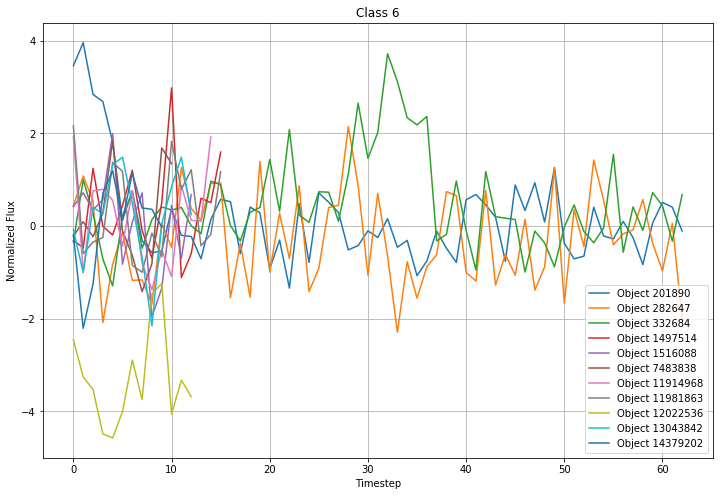

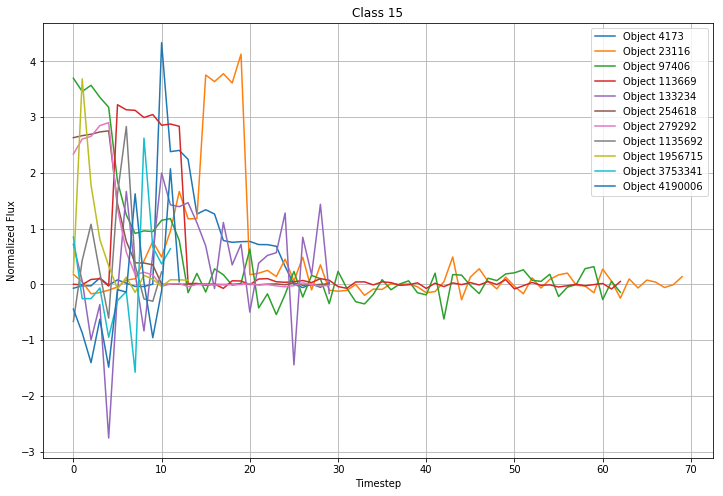

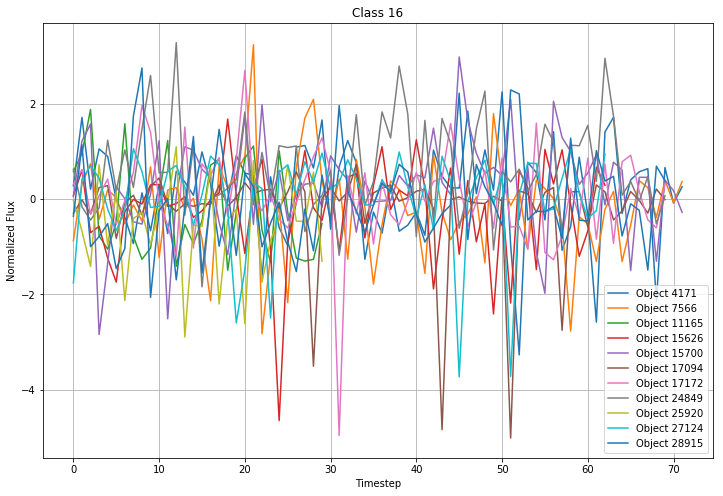

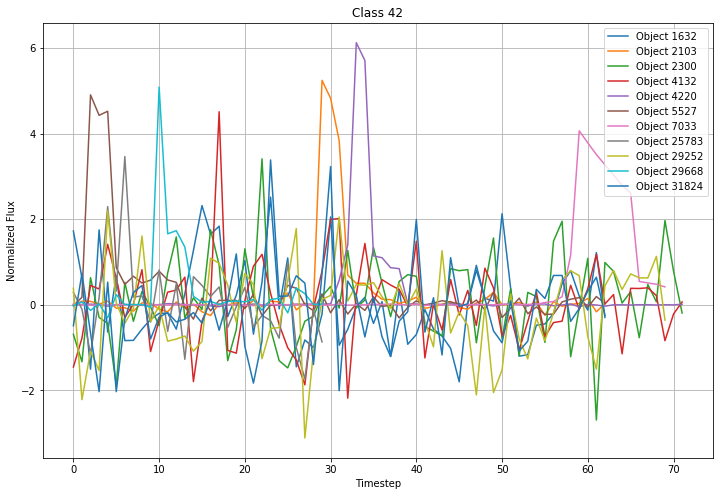

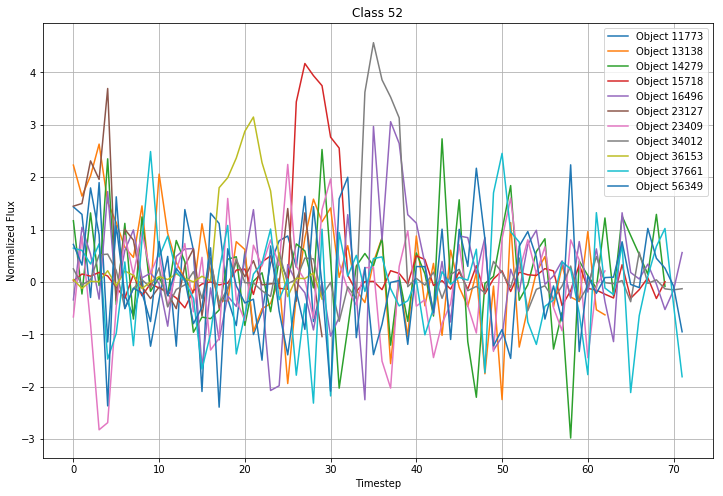

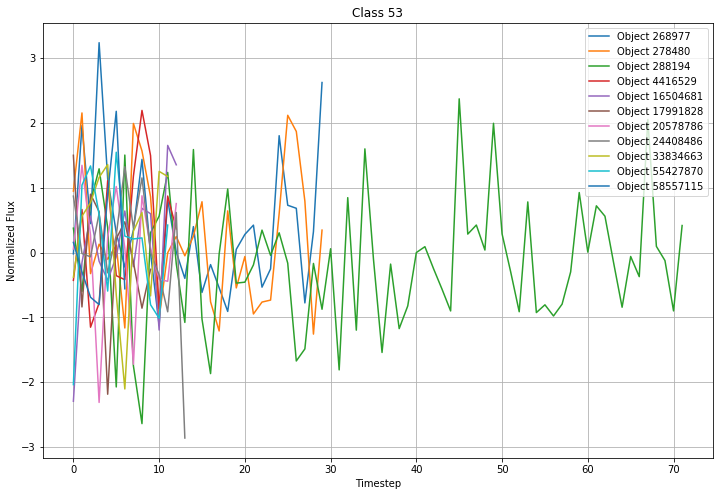

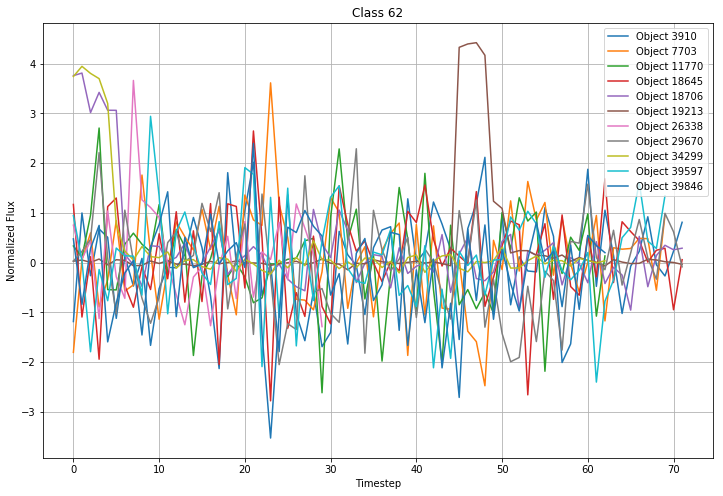

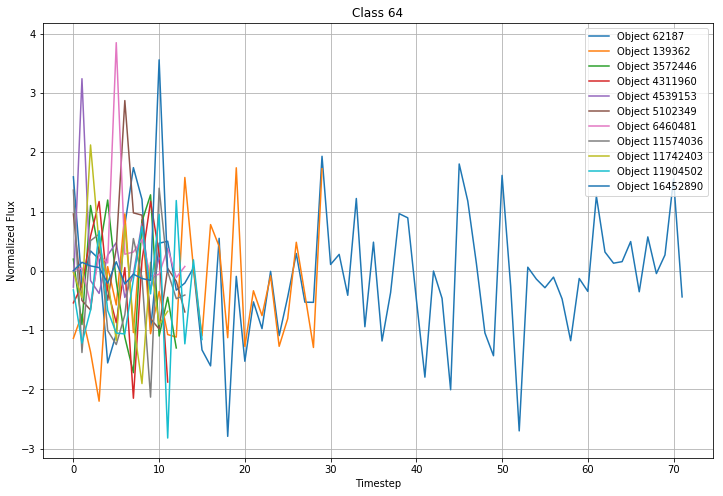

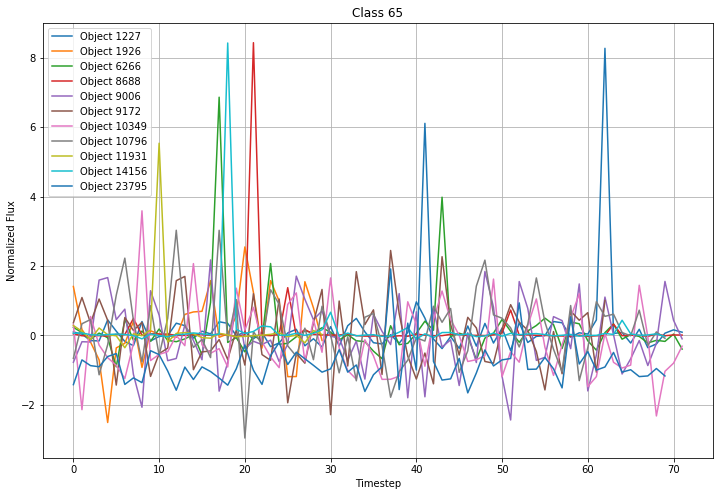

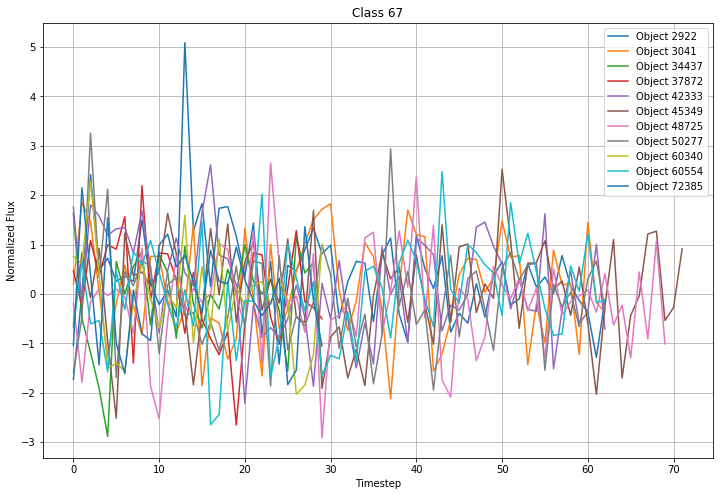

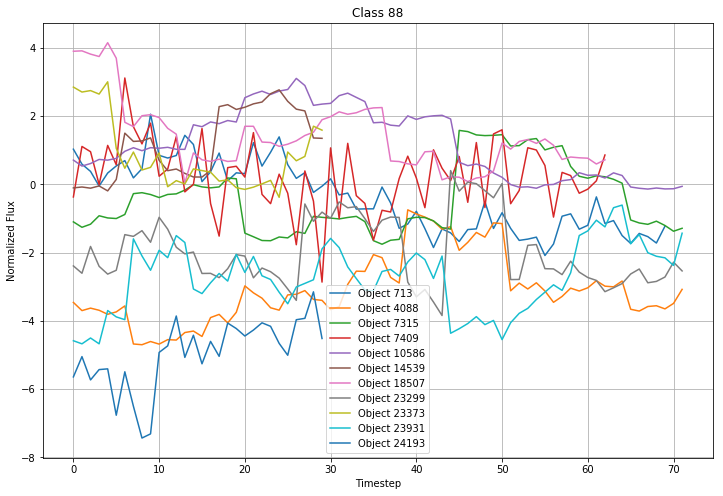

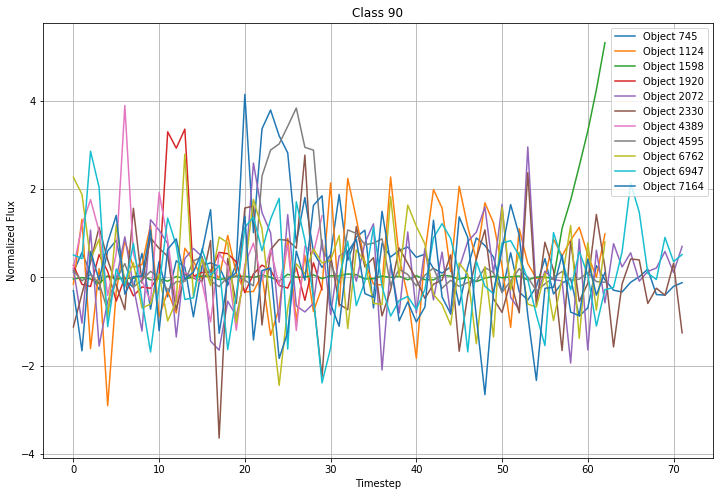

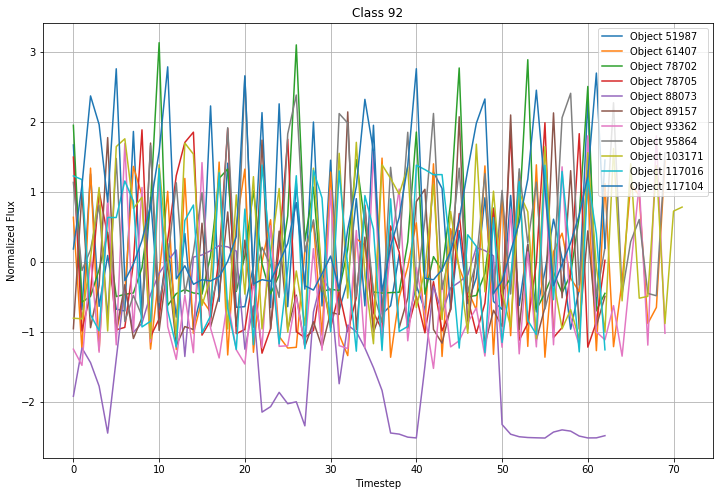

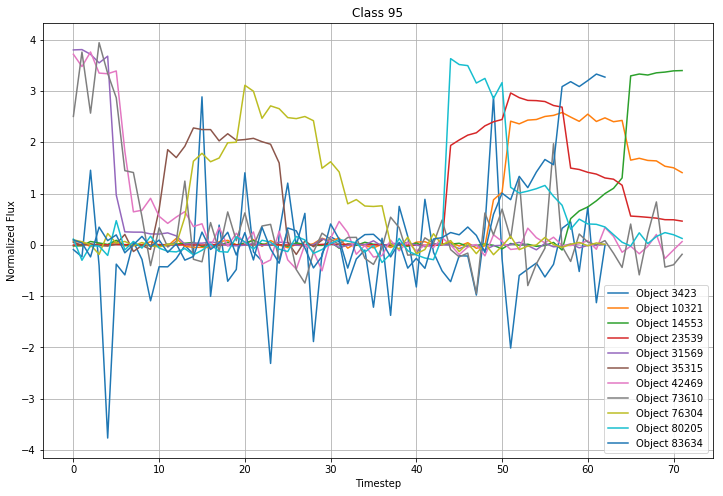

In [15]:
# Plot some examples of the time series data

df3 = df_train.join(df_train_meta.set_index('object_id'), on='object_id')

for target, df0 in df3.groupby('target'):
    graph_count = 0
    for object_id, df1 in df0.groupby('object_id'):
        for passband, df2 in df1.groupby('passband'):
            if passband != 0:
                continue
            plt.plot(range(len(df2.flux)), df2.flux/np.std(df2.flux), label='Object {}'.format(object_id))

        if graph_count == 10:
            break
        graph_count += 1
        
    plt.grid()
    plt.legend(loc='best')
    plt.title('Class {}'.format(target))
    plt.xlabel('Timestep')
    plt.ylabel('Normalized Flux')
    plt.show()

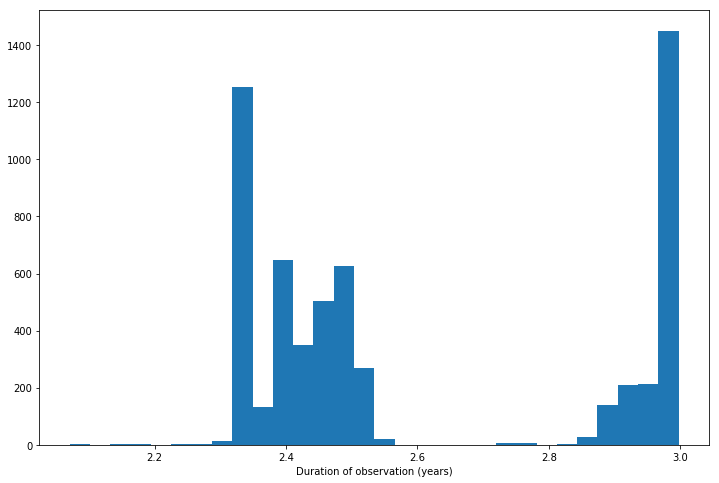

In [16]:
# plot histogram of the observation duration (first to last observation)

df1 = df_train.groupby(['object_id'])[['mjd']].agg(['min', 'max'])
plt.hist((df1.loc[:,('mjd','max')] - df1.loc[:,('mjd','min')]) / 365., bins=30)
plt.xlabel('Duration of observation (years)')
plt.show()

In [17]:
# Confirm that every object is observed in every passband 
n_passbands = len(df_train.passband.unique())
print('There are {} passband filters'.format(n_passbands))
for _, df1 in df_train.groupby('object_id'):
    assert(len(df1.passband.unique()) == n_passbands)

There are 6 passband filters


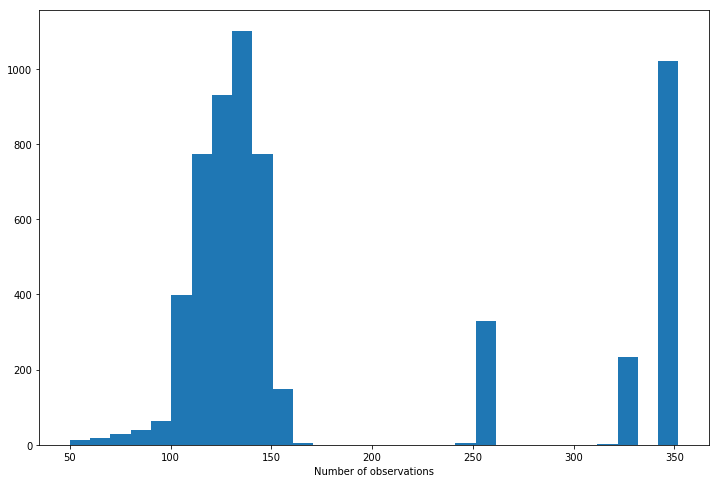

In [18]:
# plot histogram of the observation duration (first to last observation)

df1 = df_train.groupby(['object_id'])[['passband']].agg(['count'])
plt.hist(df1.loc[:,('passband', 'count')], bins=30)
plt.xlabel('Number of observations')
plt.show()

# Cost function

In [7]:
# Mimic the Kaggle evaluation function, which is a cross-entropy loss, weighted so that each class is equal
# (except classes 15, 64, and 99, which each have double the weight of other classes)

from sklearn.metrics import log_loss

def weighted_logloss(actuals, preds, weights=None, verbose=False):
    w = {99: 2.}
    for c in df_train_meta.target.unique():
        w[c] = 2. if c in [15, 64, 99] else 1.
    
    if weights is None:
        weights = w
    
    preds /= np.sum(preds, axis=0)
    preds = np.clip(preds, 1e-15, 1-1e-15)
    
    log_losses, ws = [], []
    for i, c in enumerate(sorted(weights)):
        idx = np.where(actuals == c)[0]
        if verbose:
            print('Number of true class {} examples: {}'.format(i, len(idx)))
        log_losses.append(np.mean(np.log(preds[i, idx])) if len(idx) > 0 else 0)
        ws.append(weights[c])
        
    if verbose:
        print(log_losses, ws)
    
    return -np.average(log_losses, weights=ws)

In [8]:
test_actuals = np.array(df_train_meta.target)
test_actuals = np.concatenate([test_actuals])

In [9]:
for i in range(n_classes):
    preds = np.zeros((n_classes, m_train))
    preds[i, :] = 1.
    print('WeightedLogLoss for prediction of class {} is {}.'.format(classes[i], weighted_logloss(test_actuals, preds, verbose=False)))

WeightedLogLoss for prediction of class 6 is 28.7823136624.
WeightedLogLoss for prediction of class 15 is 26.8634927516.
WeightedLogLoss for prediction of class 16 is 28.7823136624.
WeightedLogLoss for prediction of class 42 is 28.7823136624.
WeightedLogLoss for prediction of class 52 is 28.7823136624.
WeightedLogLoss for prediction of class 53 is 28.7823136624.
WeightedLogLoss for prediction of class 62 is 28.7823136624.
WeightedLogLoss for prediction of class 64 is 26.8634927516.
WeightedLogLoss for prediction of class 65 is 28.7823136624.
WeightedLogLoss for prediction of class 67 is 28.7823136624.
WeightedLogLoss for prediction of class 88 is 28.7823136624.
WeightedLogLoss for prediction of class 90 is 28.7823136624.
WeightedLogLoss for prediction of class 92 is 28.7823136624.
WeightedLogLoss for prediction of class 95 is 28.7823136624.


In [22]:
preds = np.ones((n_classes, m_train))
print('WeightedLogLoss for uniform prediction is', weighted_logloss(test_actuals, preds))

preds = np.ones((n_classes, m_train))
preds[1, :] = 2
preds[7, :] = 2
print('WeightedLogLoss for weighted unif prediction is', weighted_logloss(test_actuals, preds))

WeightedLogLoss for uniform prediction is 2.345828737435786
WeightedLogLoss for weighted unif prediction is 2.310490601866485


# Evaluation Metric: weighted accuracy

In [10]:
from sklearn.metrics import confusion_matrix

def weighted_accuracy(actuals, preds):
    cm = confusion_matrix(actuals, preds, classes)
    # normalize confusion matrix, so that summing over predicted classes equals 1
    cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)
    return np.trace(cm) / len(cm)

In [11]:
for i in range(n_classes):
    preds = [classes[i]]*len(test_actuals)
    print('WeightedAccuracy for prediction of class {} is {}.'.format(classes[i], weighted_accuracy(test_actuals, preds)))

WeightedAccuracy for prediction of class 6 is 0.0714285714286.
WeightedAccuracy for prediction of class 15 is 0.0714285714286.
WeightedAccuracy for prediction of class 16 is 0.0714285714286.
WeightedAccuracy for prediction of class 42 is 0.0714285714286.
WeightedAccuracy for prediction of class 52 is 0.0714285714286.
WeightedAccuracy for prediction of class 53 is 0.0714285714286.
WeightedAccuracy for prediction of class 62 is 0.0714285714286.
WeightedAccuracy for prediction of class 64 is 0.0714285714286.
WeightedAccuracy for prediction of class 65 is 0.0714285714286.
WeightedAccuracy for prediction of class 67 is 0.0714285714286.
WeightedAccuracy for prediction of class 88 is 0.0714285714286.
WeightedAccuracy for prediction of class 90 is 0.0714285714286.
WeightedAccuracy for prediction of class 92 is 0.0714285714286.
WeightedAccuracy for prediction of class 95 is 0.0714285714286.


In [12]:
import seaborn as sns

def plot_confusion_matrix(actuals, preds):
    cm = confusion_matrix(actuals, preds, classes)
    # normalize confusion matrix, so that summing over predicted classes equals 1
    cm = cm.astype('float') / np.sum(cm, axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(9,7))
    sns.heatmap(cm, xticklabels=classes, yticklabels=classes, cmap='Blues', annot=np.around(cm, 2), lw=0.5,
               vmin=0, vmax=1)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_aspect('equal')
    ax.set_title('Weighted accuracy: {:.2%}'.format(weighted_accuracy(actuals, preds)))

# Baseline Models

### Only metadata (no Time Series data)

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
X = np.array(df_train_meta.iloc[:, 1:-1].fillna(0))
y = np.array(df_train_meta.iloc[:, -1])

X_dev = np.array(df_dev_meta.iloc[:, 1:-1].fillna(0))
y_dev = np.array(df_dev_meta.iloc[:, -1])

In [28]:
for C in np.logspace(-3,3,7):
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', C=C)
    clf.fit(X, y)
    print('WeightedLogLoss (train) for C =', C, 'is', weighted_logloss(y, clf.predict_proba(X).T))
    print('WeightedLogLoss (dev) for C =', C, 'is', weighted_logloss(y_dev, clf.predict_proba(X_dev).T))
    print()

WeightedLogLoss (train) for C = 0.001 is 2.3481777742077887
WeightedLogLoss (dev) for C = 0.001 is 2.336137823213891

WeightedLogLoss (train) for C = 0.01 is 2.3241193356065937
WeightedLogLoss (dev) for C = 0.01 is 2.311946740651922

WeightedLogLoss (train) for C = 0.1 is 2.3413119005731176
WeightedLogLoss (dev) for C = 0.1 is 2.335416175560211

WeightedLogLoss (train) for C = 1.0 is 2.3357636262636143
WeightedLogLoss (dev) for C = 1.0 is 2.3278896167047334

WeightedLogLoss (train) for C = 10.0 is 2.3350746896276076
WeightedLogLoss (dev) for C = 10.0 is 2.3253592876763713

WeightedLogLoss (train) for C = 100.0 is 2.3282739049708927
WeightedLogLoss (dev) for C = 100.0 is 2.317935848598331

WeightedLogLoss (train) for C = 1000.0 is 2.334470475529239
WeightedLogLoss (dev) for C = 1000.0 is 2.3291412879682465



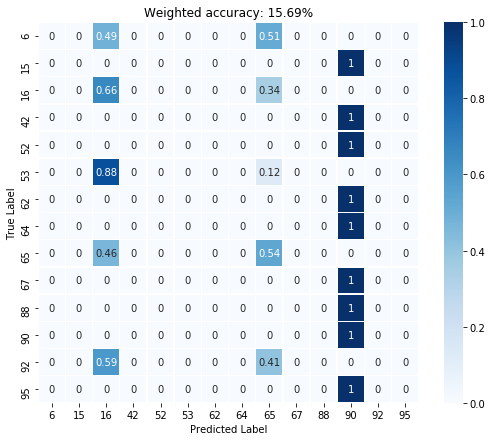

In [29]:
plot_confusion_matrix(y_dev, clf.predict(X_dev))

### Only metadata, plus normalize inputs to 0 mean, unit variance

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
C = 1.

clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', C=C)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_dev_scaled = scaler.transform(X_dev)
clf.fit(X_scaled, y)

print('WeightedLogLoss (train) with StandardScalar is', weighted_logloss(y, clf.predict_proba(X_scaled).T))
print('WeightedLogLoss (dev) with StandardScalar is', weighted_logloss(y_dev, clf.predict_proba(X_dev_scaled).T))
print()

WeightedLogLoss (train) with StandardScalar is 1.832794154048444
WeightedLogLoss (dev) with StandardScalar is 1.8764605755955495



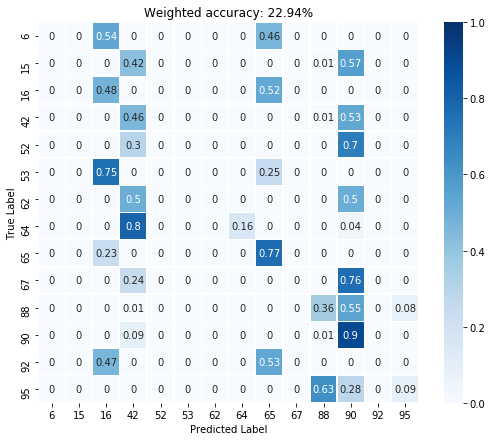

In [32]:
plot_confusion_matrix(y_dev, clf.predict(X_dev_scaled))

### Only metadata, normalize, plus equalize classes

In [33]:
for mult in 2**np.arange(5):
    C = 1e-2

    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', C=C)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_dev_scaled = scaler.transform(X_dev)

    w = Counter(y)
    p = [1./w[target] for target in y]
    idx = np.random.choice(len(y), size=int(mult)*len(y), replace=True, p=p/np.sum(p))
    clf.fit(X_scaled[idx,:], y[idx])

    print('WeightedLogLoss (train) with mult =', mult, 'is', weighted_logloss(y, clf.predict_proba(scaler.transform(X)).T))
    print('WeightedLogLoss (dev) with mult =', mult, 'is', weighted_logloss(y_dev, clf.predict_proba(X_dev_scaled).T))
    print()

WeightedLogLoss (train) with mult = 1 is 1.5785925712779625
WeightedLogLoss (dev) with mult = 1 is 1.610871129369479

WeightedLogLoss (train) with mult = 2 is 1.5177659397854506
WeightedLogLoss (dev) with mult = 2 is 1.5610768776149202

WeightedLogLoss (train) with mult = 4 is 1.4630579534821422
WeightedLogLoss (dev) with mult = 4 is 1.505590339883472

WeightedLogLoss (train) with mult = 8 is 1.4264584114114784
WeightedLogLoss (dev) with mult = 8 is 1.4705899250222854

WeightedLogLoss (train) with mult = 16 is 1.4015621458171772
WeightedLogLoss (dev) with mult = 16 is 1.4498619864421793



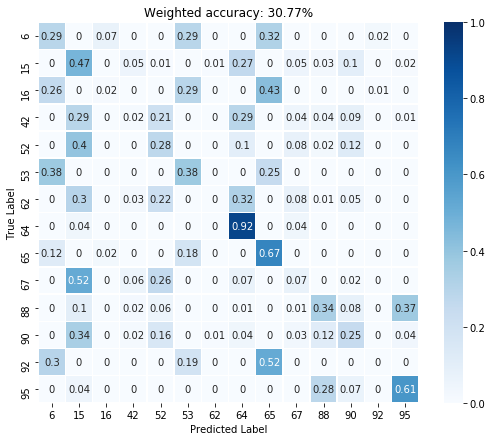

In [34]:
plot_confusion_matrix(y_dev, clf.predict(X_dev_scaled))

### Metadata, plus derived TimeSeries features

In [17]:
# Derive some simple features, like min, max, etc from the time series fluxes
ts_simple_features = df_train.groupby('object_id')[['flux']].agg(['min', 'max', 'mean', 'std', 'median', 'skew'])
ts_simple_features.columns = ts_simple_features.columns.droplevel(0)
ts_simple_features.head()

min          max       mean         std    median      skew
object_id                                                                   
713       -14.735178    14.770886  -1.423351    6.471144 -0.873033  0.014989
745       -15.494463   220.795212   8.909206   27.558208  1.035895  4.979826
1124      -16.543753   143.600189   7.145702   20.051722  1.141288  4.406298
1227      -12.695161    71.678154   0.367212    4.962633  0.208109  9.125056
1598      -13.854152  1448.715698  30.333023  167.317942  0.337299  6.278757

In [18]:
# Join with metadata
X = df_train_meta.set_index('object_id').drop('target', axis=1) \
    .join(ts_simple_features, how='inner')
assert(len(df_train_meta) == len(X))

# Convert to np arrays
X = np.array(X.fillna(0))
y = np.array(df_train_meta.iloc[:, -1])

# Scale to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Compute same features for dev set
ts_simple_features_dev = df_dev.groupby('object_id')[['flux']].agg(['min', 'max', 'mean', 'std', 'median', 'skew'])
ts_simple_features_dev.columns = ts_simple_features_dev.columns.droplevel(0)

X_dev = df_dev_meta.set_index('object_id').drop('target', axis=1) \
    .join(ts_simple_features_dev, how='inner')
assert(len(df_dev_meta) == len(X_dev))

X_dev = np.array(X_dev.fillna(0))
y_dev = np.array(df_dev_meta.iloc[:, -1])

X_dev_scaled = scaler.transform(X_dev)

In [38]:
for C in np.logspace(-3,3,7):
    mult = 8
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', C=C)

    w = Counter(y)
    p = [1./w[target] for target in y]
    idx = np.random.choice(len(y), size=int(mult)*len(y), replace=True, p=p/np.sum(p))
    clf.fit(X_scaled[idx,:], y[idx])

    print('WeightedLogLoss (train) for C =', C, 'is', weighted_logloss(y, clf.predict_proba(X_scaled).T))
    print('WeightedLogLoss (dev) for C =', C, 'is', weighted_logloss(y_dev, clf.predict_proba(X_dev_scaled).T))

WeightedLogLoss (train) for C = 0.001 is 1.3975800978494926
WeightedLogLoss (dev) for C = 0.001 is 1.4383349758835073
WeightedLogLoss (train) for C = 0.01 is 1.1618142856875266
WeightedLogLoss (dev) for C = 0.01 is 1.2293279483067505
WeightedLogLoss (train) for C = 0.1 is 1.0759129762628177
WeightedLogLoss (dev) for C = 0.1 is 1.1468653203241157
WeightedLogLoss (train) for C = 1.0 is 1.0421760028738507
WeightedLogLoss (dev) for C = 1.0 is 1.1329277376583207
WeightedLogLoss (train) for C = 10.0 is 1.0456721704867602
WeightedLogLoss (dev) for C = 10.0 is 1.1256103767288395
WeightedLogLoss (train) for C = 100.0 is 1.0414064061364694
WeightedLogLoss (dev) for C = 100.0 is 1.127597676836958
WeightedLogLoss (train) for C = 1000.0 is 1.0360886133118412
WeightedLogLoss (dev) for C = 1000.0 is 1.1051892425405434


In [43]:
for mult in 2**np.arange(6):
    C = 1.0
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', C=C)

    w = Counter(y)
    p = [1./w[target] for target in y]
    idx = np.random.choice(len(y), size=int(mult)*len(y), replace=True, p=p/np.sum(p))
    clf.fit(X_scaled[idx,:], y[idx])

    print('WeightedLogLoss (train) for mult =', mult, 'is', weighted_logloss(y, clf.predict_proba(X_scaled).T))
    print('WeightedLogLoss (dev) for mult =', mult, 'is', weighted_logloss(y_dev, clf.predict_proba(X_dev_scaled).T))

WeightedLogLoss (train) for mult = 1 is 1.0768475295174273
WeightedLogLoss (dev) for mult = 1 is 1.1168991129216908
WeightedLogLoss (train) for mult = 2 is 1.0649299923570277
WeightedLogLoss (dev) for mult = 2 is 1.1336115010900876
WeightedLogLoss (train) for mult = 4 is 1.0492266370294354
WeightedLogLoss (dev) for mult = 4 is 1.1337474310238218
WeightedLogLoss (train) for mult = 8 is 1.0475620238908336
WeightedLogLoss (dev) for mult = 8 is 1.13492916956319
WeightedLogLoss (train) for mult = 16 is 1.0366867401583613
WeightedLogLoss (dev) for mult = 16 is 1.110263587836582
WeightedLogLoss (train) for mult = 32 is 1.0444370415082367
WeightedLogLoss (dev) for mult = 32 is 1.1464756576006176


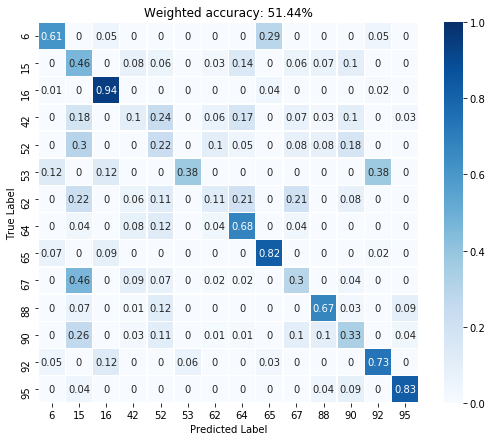

In [44]:
plot_confusion_matrix(y_dev, clf.predict(X_dev_scaled))

# PyTorch

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [23]:
class LogisticNet(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticNet, self).__init__()
        self.fc = nn.Linear(n_features, n_classes)

    def forward(self, x):
        x = self.fc(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = LogisticNet(X.shape[1], n_classes)
print(net)

LogisticNet(
  (fc): Linear(in_features=16, out_features=14, bias=True)
)


In [32]:
# %%time

class_label_to_idx = {j:i for i,j in enumerate(classes)}

# initialize NN
net = LogisticNet(X.shape[1], n_classes)

# create your optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

n_epochs = 8
for epoch in range(n_epochs):  # loop over the dataset multiple times
    w = Counter(y)
    p = [1./w[target] for target in y]
    idx = np.random.choice(len(y), size=100000, replace=True, p=p/np.sum(p))
    
    running_loss = []
    minibatch = 100
    for i in xrange(0, 100000/minibatch):
        # get the inputs
        mini_idx = idx[i*minibatch:(i+1)*minibatch]
        inputs = torch.from_numpy(X_scaled[mini_idx,:]).type(torch.FloatTensor)
        labels = torch.tensor([class_label_to_idx[label] for label in y[mini_idx]])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())
        if i % 500 == 499:    # print every 100 mini-batches
            with torch.no_grad():
                dev_pred = net(torch.from_numpy(X_dev_scaled).type(torch.FloatTensor))
                test_loss = weighted_logloss(y_dev, F.softmax(dev_pred, dim=-1).numpy().T,
                                             weights={c : 1. for c in classes})
            print('[%d, %6d], Training loss: %.3f, Dev loss: %.3f' %
                  (epoch + 1, i + 1, np.mean(running_loss), test_loss))
            running_loss = []

print('Finished Training')

[1,    500], Training loss: 1.636, Dev loss: 1.439
[1,   1000], Training loss: 1.351, Dev loss: 1.351
[2,    500], Training loss: 1.283, Dev loss: 1.324
[2,   1000], Training loss: 1.259, Dev loss: 1.310
[3,    500], Training loss: 1.231, Dev loss: 1.312
[3,   1000], Training loss: 1.220, Dev loss: 1.291
[4,    500], Training loss: 1.209, Dev loss: 1.298
[4,   1000], Training loss: 1.198, Dev loss: 1.273
[5,    500], Training loss: 1.200, Dev loss: 1.297
[5,   1000], Training loss: 1.198, Dev loss: 1.281
[6,    500], Training loss: 1.183, Dev loss: 1.301
[6,   1000], Training loss: 1.177, Dev loss: 1.302
[7,    500], Training loss: 1.181, Dev loss: 1.306
[7,   1000], Training loss: 1.183, Dev loss: 1.316
[8,    500], Training loss: 1.180, Dev loss: 1.301
[8,   1000], Training loss: 1.166, Dev loss: 1.292
Finished Training


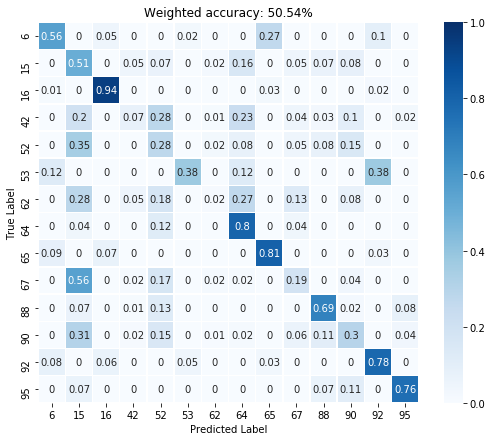

In [33]:
y_dev_pred = np.array(classes)[torch.max(dev_pred, 1)[1]]
plot_confusion_matrix(y_dev, y_dev_pred)

In [34]:
%%time

class_label_to_idx = {j:i for i,j in enumerate(classes)}

# initialize NN
net = LogisticNet(X.shape[1], n_classes)

# create your optimizer
w = torch.tensor([1./i[1] for i in sorted(Counter(y).items())])
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.Adam(net.parameters(), lr=0.01)

n_epochs = 2000
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    # get the inputs
    inputs = torch.from_numpy(X_scaled).type(torch.FloatTensor)
    labels = torch.tensor([class_label_to_idx[label] for label in y])

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 50 == 49:
        with torch.no_grad():
            dev_pred = net(torch.from_numpy(X_dev_scaled).type(torch.FloatTensor))
            test_loss = weighted_logloss(y_dev, F.softmax(dev_pred, dim=-1).numpy().T,
                                             weights={c : 1. for c in classes})
        print('[%d], Training loss: %.3f, Dev loss: %.3f' %
              (epoch + 1, loss.item(), test_loss))

print('Finished Training')

[50], Training loss: 1.758, Dev loss: 1.794
[100], Training loss: 1.534, Dev loss: 1.597
[150], Training loss: 1.436, Dev loss: 1.507
[200], Training loss: 1.380, Dev loss: 1.456
[250], Training loss: 1.343, Dev loss: 1.422
[300], Training loss: 1.317, Dev loss: 1.399
[350], Training loss: 1.297, Dev loss: 1.381
[400], Training loss: 1.281, Dev loss: 1.367
[450], Training loss: 1.268, Dev loss: 1.355
[500], Training loss: 1.258, Dev loss: 1.346
[550], Training loss: 1.248, Dev loss: 1.338
[600], Training loss: 1.241, Dev loss: 1.331
[650], Training loss: 1.234, Dev loss: 1.325
[700], Training loss: 1.228, Dev loss: 1.320
[750], Training loss: 1.222, Dev loss: 1.316
[800], Training loss: 1.217, Dev loss: 1.311
[850], Training loss: 1.213, Dev loss: 1.308
[900], Training loss: 1.209, Dev loss: 1.304
[950], Training loss: 1.205, Dev loss: 1.300
[1000], Training loss: 1.202, Dev loss: 1.296
[1050], Training loss: 1.198, Dev loss: 1.293
[1100], Training loss: 1.196, Dev loss: 1.290
[1150], 

In [41]:
# %%time

class_label_to_idx = {j:i for i,j in enumerate(classes)}

# initialize NN
net = LogisticNet(X.shape[1], n_classes)

# create your optimizer
w = torch.tensor([1./i[1] for i in sorted(Counter(y).items())])
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.Adam(net.parameters(), lr=0.01)

n_epochs = 2000
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    # get the inputs
    inputs = torch.from_numpy(X_scaled).type(torch.FloatTensor)
    labels = torch.tensor([class_label_to_idx[label] for label in y])

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 50 == 49:
        with torch.no_grad():
            dev_pred = net(torch.from_numpy(X_dev_scaled).type(torch.FloatTensor))
            test_loss = criterion(dev_pred, torch.tensor([class_label_to_idx[c] for c in y_dev])).item()
        print('[%d], Training loss: %.3f, Dev loss: %.3f' %
              (epoch + 1, loss.item(), test_loss))

print('Finished Training')

[50], Training loss: 1.778, Dev loss: 1.829
[100], Training loss: 1.547, Dev loss: 1.620
[150], Training loss: 1.447, Dev loss: 1.530
[200], Training loss: 1.390, Dev loss: 1.480
[250], Training loss: 1.353, Dev loss: 1.448
[300], Training loss: 1.326, Dev loss: 1.424
[350], Training loss: 1.306, Dev loss: 1.406
[400], Training loss: 1.290, Dev loss: 1.392
[450], Training loss: 1.277, Dev loss: 1.380
[500], Training loss: 1.266, Dev loss: 1.370
[550], Training loss: 1.257, Dev loss: 1.361
[600], Training loss: 1.249, Dev loss: 1.354
[650], Training loss: 1.241, Dev loss: 1.347
[700], Training loss: 1.235, Dev loss: 1.342
[750], Training loss: 1.229, Dev loss: 1.336
[800], Training loss: 1.224, Dev loss: 1.331
[850], Training loss: 1.219, Dev loss: 1.327
[900], Training loss: 1.215, Dev loss: 1.323
[950], Training loss: 1.210, Dev loss: 1.319
[1000], Training loss: 1.207, Dev loss: 1.316
[1050], Training loss: 1.203, Dev loss: 1.312
[1100], Training loss: 1.200, Dev loss: 1.309
[1150], 

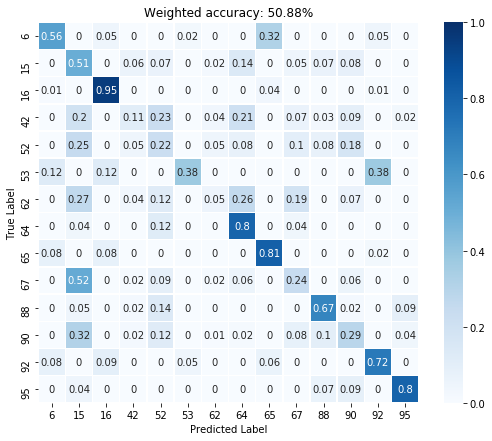

In [42]:
y_dev_pred = np.array(classes)[torch.max(dev_pred, 1)[1]]
plot_confusion_matrix(y_dev, y_dev_pred)

In [26]:
class Net(nn.Module):
    def __init__(self, n_features, n_classes, n_hiddenunits):
        super(Net, self).__init__()
        
        # 2-layer NN
        self.fc1 = nn.Linear(n_features, n_hiddenunits)
        self.fc2 = nn.Linear(n_hiddenunits, n_classes)
        self.d = nn.Dropout(p=0.0)

    def forward(self, x):
        x = self.fc1(x)
        x = self.d(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net(X.shape[1], n_classes, 4)
print(net)

Net(
  (fc1): Linear(in_features=16, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=14, bias=True)
  (d): Dropout(p=0.0)
)


In [27]:
%%time

class_label_to_idx = {j:i for i,j in enumerate(classes)}

# initialize NN
net = Net(X.shape[1], n_classes, 4)

# create your optimizer
w = torch.tensor([1./i[1] for i in sorted(Counter(y).items())])
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.Adam(net.parameters(), lr=0.01)

n_epochs = 1000
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    # get the inputs
    inputs = torch.from_numpy(X_scaled).type(torch.FloatTensor)
    labels = torch.tensor([class_label_to_idx[label] for label in y])

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 50 == 49:
        with torch.no_grad():
            dev_pred = net(torch.from_numpy(X_dev_scaled).type(torch.FloatTensor))
            test_loss = weighted_logloss(y_dev, F.softmax(dev_pred, dim=-1).numpy().T)
        print('[%d], Training loss: %.3f, Dev loss: %.3f' %
              (epoch + 1, loss.item(), test_loss))

    
print('Finished Training')

[50], Training loss: 1.763, Dev loss: 1.603
[100], Training loss: 1.451, Dev loss: 1.346
[150], Training loss: 1.356, Dev loss: 1.275
[200], Training loss: 1.287, Dev loss: 1.212
[250], Training loss: 1.248, Dev loss: 1.176
[300], Training loss: 1.228, Dev loss: 1.158
[350], Training loss: 1.216, Dev loss: 1.147
[400], Training loss: 1.208, Dev loss: 1.141
[450], Training loss: 1.201, Dev loss: 1.136
[500], Training loss: 1.196, Dev loss: 1.133
[550], Training loss: 1.192, Dev loss: 1.131
[600], Training loss: 1.190, Dev loss: 1.133
[650], Training loss: 1.185, Dev loss: 1.128
[700], Training loss: 1.181, Dev loss: 1.121
[750], Training loss: 1.178, Dev loss: 1.120
[800], Training loss: 1.176, Dev loss: 1.119
[850], Training loss: 1.174, Dev loss: 1.119
[900], Training loss: 1.172, Dev loss: 1.118
[950], Training loss: 1.169, Dev loss: 1.113
[1000], Training loss: 1.166, Dev loss: 1.112
Finished Training
CPU times: user 17.9 s, sys: 614 ms, total: 18.5 s
Wall time: 6.89 s


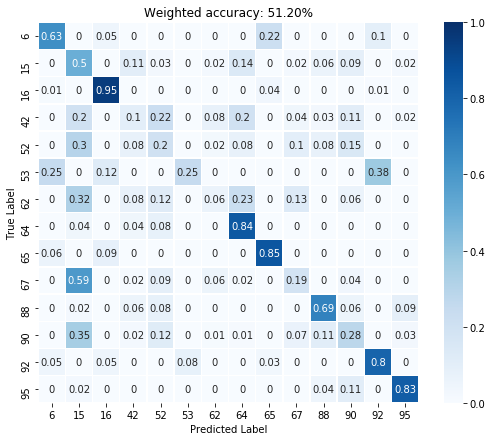

In [28]:
y_dev_pred = np.array(classes)[torch.max(dev_pred, 1)[1]]
plot_confusion_matrix(y_dev, y_dev_pred)

# Add some time series points

In [185]:
%%time
include_time_series_points = 50

# Derive some simple features, like min, max, etc from the time series fluxes
ts_simple_features = df_train.groupby('object_id')[['flux']].agg(['min', 'max', 'mean', 'std', 'median', 'skew'])
ts_simple_features.columns = ts_simple_features.columns.droplevel(0)
for i in xrange(include_time_series_points):
    ts_simple_features[str(i)] = df_train.groupby('object_id')[['flux']].nth(i)

# Join with metadata
X = df_train_meta.set_index('object_id').drop('target', axis=1) \
    .join(ts_simple_features, how='inner')
assert(len(df_train_meta) == len(X))

# Convert to np arrays
X = np.array(X.fillna(0))[:,-include_time_series_points:]
y = np.array(df_train_meta.iloc[:, -1])

# Scale to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Compute same features for dev set
ts_simple_features_dev = df_dev.groupby('object_id')[['flux']].agg(['min', 'max', 'mean', 'std', 'median', 'skew'])
ts_simple_features_dev.columns = ts_simple_features_dev.columns.droplevel(0)
for i in xrange(include_time_series_points):
    ts_simple_features_dev[str(i)] = df_dev.groupby('object_id')[['flux']].nth(i)

X_dev = df_dev_meta.set_index('object_id').drop('target', axis=1) \
    .join(ts_simple_features_dev, how='inner')
assert(len(df_dev_meta) == len(X_dev))

X_dev = np.array(X_dev.fillna(0))[:,-include_time_series_points:]
y_dev = np.array(df_dev_meta.iloc[:, -1])

X_dev_scaled = scaler.transform(X_dev)

CPU times: user 10.2 s, sys: 1.66 s, total: 11.8 s
Wall time: 13.3 s


In [186]:
class Net(nn.Module):
    def __init__(self, n_features, n_classes, n_hiddenunits):
        super(Net, self).__init__()
        # 2-layer NN
        self.fc1 = nn.Linear(n_features, n_hiddenunits)
        self.fc2 = nn.Linear(n_hiddenunits, n_classes)
        self.d = nn.Dropout(p=0.1)

    def forward(self, x):
        x = self.fc1(x)
#         x = self.d(x)
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net(X.shape[1], n_classes, 4)
print(net)

Net(
  (fc1): Linear(in_features=50, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=14, bias=True)
  (d): Dropout(p=0.1)
)


[1], Training loss: 2.812, Dev loss: 2.467
[101], Training loss: 2.370, Dev loss: 2.332
[201], Training loss: 2.332, Dev loss: 2.520
[301], Training loss: 2.324, Dev loss: 2.675
[401], Training loss: 2.318, Dev loss: 2.774
[501], Training loss: 2.315, Dev loss: 2.870
[601], Training loss: 2.313, Dev loss: 2.956
[701], Training loss: 2.312, Dev loss: 3.016
[801], Training loss: 2.311, Dev loss: 3.071
[901], Training loss: 2.310, Dev loss: 3.125
[1001], Training loss: 2.309, Dev loss: 3.181
[1101], Training loss: 2.336, Dev loss: 3.030
[1201], Training loss: 2.312, Dev loss: 3.147
[1301], Training loss: 2.310, Dev loss: 3.160
[1401], Training loss: 2.309, Dev loss: 3.195
[1501], Training loss: 2.309, Dev loss: 3.230
[1601], Training loss: 2.308, Dev loss: 3.262
[1701], Training loss: 2.308, Dev loss: 3.294
[1801], Training loss: 2.308, Dev loss: 3.325
[1901], Training loss: 2.308, Dev loss: 3.355
Finished Training
CPU times: user 43.3 s, sys: 1.59 s, total: 44.9 s
Wall time: 18.1 s


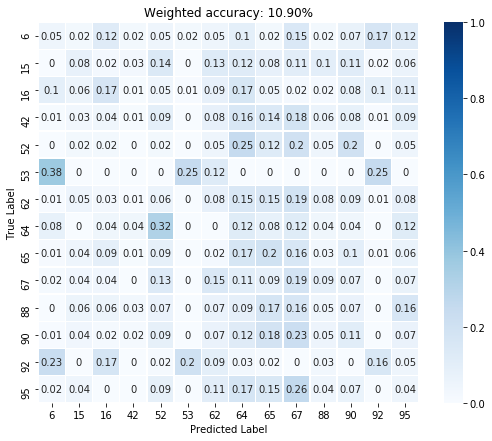

In [199]:
%%time

class_label_to_idx = {j:i for i,j in enumerate(classes)}

# initialize NN
net = Net(X.shape[1], n_classes, 4)

# create your optimizer
w = torch.tensor([1./i[1] for i in sorted(Counter(y).items())])
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.Adam(net.parameters(), lr=0.01)

n_epochs = 2000
for epoch in range(n_epochs):  # loop over the dataset multiple times    
    # get the inputs
    inputs = torch.from_numpy(X_scaled).type(torch.FloatTensor)
    labels = torch.tensor([class_label_to_idx[label] for label in y])

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # print statistics
    if epoch % 100 == 99:
        with torch.no_grad():
            dev_pred = net(torch.from_numpy(X_dev_scaled).type(torch.FloatTensor))
            dev_loss = weighted_logloss(y_dev, F.softmax(dev_pred, dim=-1).numpy().T)
        print('[%d], Training loss: %.3f, Dev loss: %.3f' %
              (epoch + 1, loss.item(), dev_loss))

print('Finished Training')

y_dev_pred = np.array(classes)[torch.max(dev_pred, 1)[1]]
plot_confusion_matrix(y_dev, y_dev_pred)